In [3]:
import json
from typing import List

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from rich import print
import matplotlib.pyplot as plt

from src.blip_modules.blip_text_encoder import BLIPTextEncoder
from src.blip_modules.blip_img_encoder import BLIPImgEncoder
from src.data_utils import targetpad_transform
from src.fashioniq_experiment.utils import element_wise_sum_original, get_combing_function_with_alpha, \
    convert_to_pivot_fiq, prepare_and_plot_recall_pivot, prepare_ground_truths, plot_retrieval_results_of_i, \
    found_better_than_original
from src.fashioniq_experiment.validate_notebook import fiq_val_retrieval_text_image_grid_search, compute_results_fiq_val
from src.utils import device

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 1: Set up the experiment</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Set up the cache for the experiment</div>

In [4]:
cache = {}

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Same concept as script version here</div>

In [5]:
BLIP_PRETRAINED_PATH = '../../../models/model_large_retrieval_coco.pth'
MED_CONFIG_PATH = '../../blip_modules/med_config_large.json'

In [6]:
blip_text_encoder = BLIPTextEncoder(
    BLIP_PRETRAINED_PATH, 
    MED_CONFIG_PATH,
    use_pretrained_proj_layer=True,
    vit='large',
)

blip_text_encoder = blip_text_encoder.to(device)
print("blip text encoder loaded.")
blip_text_encoder.eval()

load checkpoint from ../../../models/model_large_retrieval_coco.pth for text_encoder.
load checkpoint from ../../../models/model_large_retrieval_coco.pth for text_proj.


blip text encoder loaded.

BLIPTextEncoder(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30524, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Drop

In [7]:
blip_img_encoder = BLIPImgEncoder(BLIP_PRETRAINED_PATH, vit='large')
blip_img_encoder = blip_img_encoder.to(device)
print("blip img encoder loaded.")
blip_img_encoder.eval()

load checkpoint from ../../../models/model_large_retrieval_coco.pth for visual_encoder.
load checkpoint from ../../../models/model_large_retrieval_coco.pth for vision_proj.


blip img encoder loaded.

BLIPImgEncoder(
  (visual_encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
      

In [8]:
print('Target pad preprocess pipeline is used')
preprocess = targetpad_transform(1.25, 384)

Target pad preprocess pipeline is used

In [9]:
combining_function_original = element_wise_sum_original

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 2: Load the MLLM generated text captions</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Load the addition text captions</div>

In [11]:
with open('../../../fashionIQ_dataset/labeled_images_cir_cleaned.json', 'r') as f:
    text_captions = json.load(f)
    
total_recall_list: List[List[pd.DataFrame]] = []

print(f'Total number of text captions: {len(text_captions)}')

Total number of text captions: 74357

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 3: Perform retrieval on the FashionIQ dataset</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the shirt category</div>

In [12]:
grid_search_alphas = np.arange(0, 1.05, 0.05)
shirt_recall_list: List[pd.DataFrame] = []

for alpha in tqdm(grid_search_alphas, desc="Grid Search alphas and betas"):
    shirt_recall = fiq_val_retrieval_text_image_grid_search(
        'shirt',
        get_combing_function_with_alpha(alpha),
        blip_text_encoder,
        blip_img_encoder,
        text_captions,
        preprocess,
        cache=cache,
    )
    
    shirt_recall_list.append(shirt_recall)

shirt_recall_at10, shirt_recall_at50 = convert_to_pivot_fiq(shirt_recall_list)

Grid Search alphas and betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [13]:
display(shirt_recall_at10, shirt_recall_at50)

alpha      0.00      0.05      0.10      0.15      0.20       0.25       0.30  \
beta                                                                            
0.00   8.881256  8.930324  8.930324  8.930324  8.881256   8.930324   9.028459   
0.05   9.028459  9.077527  9.077527  9.126595  9.175663   9.371933   9.371933   
0.10   9.126595  9.224730  9.322865  9.273798  9.322865   9.371933   9.519137   
0.15   9.077527  9.224730  9.273798  9.421001  9.519137   9.666339   9.666339   
0.20   8.734053  8.783121  8.930324  9.126595  9.371933   9.519137   9.862611   
0.25   8.439647  8.684985  9.028459  9.175663  9.371933   9.617272   9.960746   
0.30   8.586850  8.734053  9.028459  9.421001  9.813543  10.009813  10.451423   
0.35   8.439647  8.635917  9.028459  9.322865  9.568204   9.960746  10.549559   
0.40   8.341511  8.488715  8.832189  9.224730  9.470069   9.764475  10.598626   
0.45   8.243376  8.586850  8.881256  9.224730  9.470069   9.911678  10.598626   
0.50   7.948969  8.292443  8.635917  9.126595  9.322865  10.157017  10.745829   
0.55   7.801767  8.145241  8.390579  8.783121  9.371933   9.960746  10.598626   
0.60   7.507360  7.752699  8.096173  8.586850  9.322865  10.058881  10.794897   
0.65   7.311089  7.605495  7.998037  8.832189  9.273798  10.009813  10.647694   
0.70   7.114819  7.360157  7.752699  8.194308  8.783121   9.813543  10.255152   
0.75   6.771345  7.016683  7.458293  7.948969  8.439647   9.470069  10.255152   
0.80   6.378803  6.673209  7.360157  7.998037  8.145241   8.881256  10.107949   
0.85   6.182532  6.526006  7.016683  7.507360  7.850834   8.537782   9.519137   
0.90   5.888126  6.231600  6.427871  7.016683  7.556428   8.047105   9.077527   
0.95   5.691855  5.937193  6.035329  6.476938  7.114819   7.801767   8.684985   
1.00   5.544652  5.740922  5.888126  6.280667  6.820412   7.262021   8.243376   

alpha       0.35       0.40       0.45  ...       0.55       0.60       0.65  \
beta                                    ...                                    
0.00    9.028459   9.126595   9.077527  ...   9.421001   9.421001   9.519137   
0.05    9.421001   9.519137   9.519137  ...   9.568204   9.813543  10.255152   
0.10    9.519137   9.470069   9.715407  ...  10.107949  10.402355  10.696761   
0.15    9.764475   9.862611  10.255152  ...  10.647694  11.040235  11.383709   
0.20    9.862611  10.500491  10.598626  ...  11.285574  11.579981  12.414131   
0.25   10.893033  10.942100  11.285574  ...  12.021590  12.414131  13.248283   
0.30   10.843965  11.334642  11.579981  ...  12.757605  13.395485  14.180569   
0.35   11.089303  11.432777  11.874387  ...  13.346419  14.131501  14.818449   
0.40   11.138371  11.678116  12.266929  ...  14.131501  14.916585  16.094211   
0.45   11.236507  11.923455  12.806673  ...  14.425908  15.603533  17.124632   
0.50   11.727183  12.365064  13.101080  ...  15.014720  16.388616  17.566241   
0.55   11.432777  12.659471  13.886163  ...  16.143277  17.222768  18.596664   
0.60   11.383709  12.463199  13.738960  ...  16.535820  17.664377  18.989205   
0.65   11.579981  12.414131  13.640824  ...  16.781157  18.449460  20.068695   
0.70   11.187439  12.315996  13.886163  ...  16.977429  18.940137  20.902845   
0.75   10.942100  11.923455  13.935231  ...  16.977429  18.940137  20.412169   
0.80   10.696761  11.972522  14.082433  ...  17.026496  19.087340  20.314033   
0.85   10.304220  11.383709  13.591756  ...  16.879293  19.038273  20.853779   
0.90   10.107949  11.481845  13.542689  ...  16.879293  18.989205  20.264965   
0.95    9.813543  11.040235  13.052012  ...  16.683023  18.155053  19.676153   
1.00    9.568204  10.598626  12.610403  ...  16.094211  17.615309  18.253189   

alpha       0.70       0.75       0.80       0.85       0.90       0.95  \
beta                                                                      
0.00    9.813543  10.500491  11.481845  12.659471  15.063788  24.582924   
0.05   10.696761  11.334642  12.119725  13.935231  16.143277  26.00588

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   18.989205  18.989205  19.038273  19.087340  19.283612  19.332679   
0.05   19.136408  19.479883  19.381747  19.627085  19.823356  19.921492   
0.10   19.479883  19.627085  19.627085  20.117763  20.215897  20.412169   
0.15   19.872424  20.019627  20.314033  20.657508  20.706575  20.853779   
0.20   19.676153  20.068695  20.215897  20.461236  20.804711  21.197252   
0.25   19.332679  19.676153  20.117763  20.657508  21.148184  21.491659   
0.30   19.283612  19.528949  20.019627  20.559372  21.295388  21.982336   
0.35   18.940137  19.430815  19.970560  20.608440  21.344456  22.080471   
0.40   18.694799  19.087340  19.578017  20.608440  21.295388  22.276741   
0.45   18.596664  19.136408  19.823356  20.559372  21.393523  22.325809   
0.50   17.958783  18.891069  19.528949  20.166831  21.000981  22.276741   
0.55   17.615309  18.204121  18.891069  19.823356  21.099117  22.276741   
0.60   17.222768  17.811580  18.498528  19.185476  20.755643  21.786065   
0.65   16.486752  17.419039  18.056919  19.038273  20.117763  21.295388   
0.70   15.947007  16.683023  17.468105  18.547596  19.627085  21.099117   
0.75   15.358195  16.045143  16.977429  18.155053  19.528949  20.461236   
0.80   15.063788  15.554465  16.339548  17.468105  18.989205  19.823356   
0.85   14.425908  15.063788  15.996075  16.781157  18.105987  19.381747   
0.90   13.788028  14.524043  14.965652  16.143277  17.468105  18.694799   
0.95   12.904808  13.640824  14.278704  15.456329  16.879293  18.253189   
1.00   12.463199  13.150147  13.886163  14.916585  16.143277  17.419039   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   19.528949  19.627085  19.823356  19.970560  ...  20.657508  20.853779   
0.05   20.117763  20.412169  20.608440  20.804711  ...  21.197252  21.491659   
0.10   20.559372  20.755643  21.099117  21.442591  ...  22.374877  22.767419   
0.15   21.148184  21.589793  21.835132  22.178607  ...  23.159961  23.650637   
0.20   21.491659  21.933268  22.473013  22.865555  ...  24.043180  24.828263   
0.25   21.933268  22.620216  23.061825  23.552503  ...  25.564280  26.104024   
0.30   22.473013  23.209028  23.552503  24.386653  ...  26.594701  27.281648   
0.35   22.865555  23.650637  24.141315  25.220805  ...  27.526987  28.753680   
0.40   22.865555  23.699705  24.975467  25.809616  ...  28.753680  29.931304   
0.45   23.356232  23.945044  24.926399  25.858685  ...  29.538763  30.814525   
0.50   23.159961  24.190383  25.318941  26.692837  ...  30.127576  31.697744   
0.55   23.307164  24.435721  25.564280  27.134445  ...  30.961728  33.022571   
0.60   22.816487  24.386653  25.907752  27.625123  ...  32.384691  34.151128   
0.65   22.571148  24.533857  25.809616  28.508341  ...  33.267909  35.475957   
0.70   22.276741  24.386653  26.447499  28.753680  ...  33.415112  36.506379   
0.75   21.786065  23.846909  26.202160  28.606477  ...  33.758587  36.359176   
0.80   21.884200  23.601571  25.809616  28.655544  ...  34.249264  36.751717   
0.85   21.148184  23.258096  25.466144  28.606477  ...  33.807653  36.261040   
0.90   20.755643  22.865555  25.318941  28.017664  ...  33.169773  35.819432   
0.95   19.921492  22.423945  25.122669  27.526987  ...  32.728165  34.641805   
1.00   18.842001  21.589793  24.092247  27.036309  ...  31.599608  34.298331   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   21.148184  21.491659  22.522080  23.846909  25.220805  30.078509   
0.05   21.982336  22.914623  23.552503  24.386653  27.036309  31.992149   
0.10   23.405299  23.945044  24.435721  25.809616  28.606477  33.856723   
0.15   24.288519  25.024533  25.858685  27.723259  30.5691

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the dress category</div>

In [14]:
grid_search_alphas = np.arange(0, 1.05, 0.05)
dress_recall_list: List[pd.DataFrame] = []

for alpha in tqdm(grid_search_alphas, desc="Grid Search alphas and betas"):
    dress_recall = fiq_val_retrieval_text_image_grid_search(
        'dress',
        get_combing_function_with_alpha(alpha),
        blip_text_encoder,
        blip_img_encoder,
        text_captions,
        preprocess,
        cache=cache,
    )
    
    dress_recall_list.append(dress_recall)

dress_recall_at10, dress_recall_at50 = convert_to_pivot_fiq(dress_recall_list)

Grid Search alphas and betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [15]:
display(dress_recall_at10, dress_recall_at50)

alpha      0.00      0.05      0.10      0.15      0.20      0.25      0.30  \
beta                                                                          
0.00   3.867129  3.867129  3.867129  3.916708  3.916708  4.015865  4.065444   
0.05   4.115022  4.115022  4.115022  4.164601  4.115022  4.164601  4.362915   
0.10   4.065444  4.115022  4.164601  4.214180  4.263758  4.362915  4.561229   
0.15   4.412494  4.462072  4.561229  4.610808  4.660387  4.709965  4.858701   
0.20   4.362915  4.412494  4.462072  4.511651  4.660387  4.610808  4.759544   
0.25   4.214180  4.214180  4.263758  4.462072  4.511651  4.561229  4.759544   
0.30   4.164601  4.164601  4.263758  4.362915  4.511651  4.660387  4.660387   
0.35   4.065444  4.065444  4.164601  4.164601  4.214180  4.511651  4.660387   
0.40   3.767972  3.916708  3.966286  4.015865  4.214180  4.263758  4.660387   
0.45   3.569658  3.668815  3.966286  4.015865  4.065444  4.115022  4.462072   
0.50   3.371344  3.470501  3.817551  3.966286  3.916708  4.065444  4.214180   
0.55   3.222608  3.222608  3.321765  3.420922  3.619236  3.867129  4.164601   
0.60   3.073872  3.073872  3.123451  3.222608  3.420922  3.569658  3.867129   
0.65   2.875558  2.825979  2.925136  2.875558  3.321765  3.420922  3.916708   
0.70   2.627665  2.627665  2.776401  2.825979  3.173029  3.420922  3.767972   
0.75   2.627665  2.627665  2.677243  2.925136  3.123451  3.321765  3.569658   
0.80   2.478929  2.528508  2.726822  2.875558  2.974715  3.024293  3.470501   
0.85   2.231036  2.379772  2.627665  3.024293  2.974715  3.073872  3.321765   
0.90   2.131879  2.231036  2.528508  2.875558  2.875558  3.073872  3.222608   
0.95   2.082300  2.131879  2.379772  2.677243  2.825979  2.925136  3.123451   
1.00   1.983143  2.032722  2.181458  2.429350  2.627665  2.726822  3.073872   

alpha      0.35      0.40      0.45  ...      0.55      0.60       0.65  \
beta                                 ...                                  
0.00   4.115022  4.115022  4.164601  ...  4.263758  4.412494   4.809123   
0.05   4.412494  4.462072  4.561229  ...  4.809123  4.908280   5.106594   
0.10   4.610808  4.709965  4.858701  ...  5.106594  5.354487   5.503223   
0.15   4.908280  5.007437  5.057015  ...  5.354487  5.651958   5.949430   
0.20   4.759544  4.957858  5.205751  ...  5.651958  6.098166   6.346059   
0.25   4.809123  4.858701  5.106594  ...  5.651958  6.048587   6.445216   
0.30   4.759544  4.957858  5.255330  ...  5.899851  6.395637   6.742688   
0.35   4.908280  4.957858  5.354487  ...  6.246901  6.445216   7.337630   
0.40   4.809123  5.205751  5.453644  ...  6.197323  6.742688   7.684680   
0.45   4.660387  5.156172  5.453644  ...  6.841844  7.734258   8.477937   
0.50   4.660387  5.156172  5.453644  ...  7.089737  8.081309   9.370352   
0.55   4.809123  5.304908  5.701537  ...  7.387209  8.626673  10.014874   
0.60   4.660387  5.106594  5.800694  ...  7.337630  9.419931  10.857709   
0.65   4.214180  4.660387  5.751115  ...  8.081309  9.519088  11.105602   
0.70   4.115022  4.561229  5.453644  ...  8.428359  9.866138  11.105602   
0.75   4.015865  4.561229  5.255330  ...  8.279623  9.766981  11.105602   
0.80   3.718394  4.462072  5.503223  ...  8.279623  9.965295  11.303917   
0.85   3.668815  4.313337  5.453644  ...  8.180466  9.915716  10.956866   
0.90   3.569658  4.412494  5.404066  ...  7.833416  9.519088  10.560238   
0.95   3.371344  4.362915  5.205751  ...  7.684680  9.023302  10.461081   
1.00   3.569658  4.462072  5.205751  ...  7.337630  8.874566   9.618245   

alpha       0.70       0.75       0.80       0.85       0.90       0.95  \
beta                                                                      
0.00    5.156172   5.404066   5.651958   6.593952   9.221616  18.641546   
0.05    5.453644   5.850273   6.197323   7.387209  10.163610  19.980168   
0.10    5.800694   6.048587   6.841844   7.833416  11.155181  20.575112   
0.15    5.999009   6.494794   7.337630   8.527516  12.097174  21.120475   
0.20  

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   11.452653  11.452653  11.551809  11.551809  11.551809  11.601388   
0.05   11.403074  11.452653  11.601388  11.650967  11.650967  11.750124   
0.10   11.303917  11.502231  11.700545  11.898860  12.047596  12.295488   
0.15   11.353495  11.551809  11.650967  11.948438  12.245910  12.592959   
0.20   11.056024  11.254338  11.551809  11.799703  12.345067  12.692118   
0.25   11.006445  11.155181  11.502231  11.849281  11.948438  12.444224   
0.30   10.808131  11.155181  11.551809  11.948438  12.245910  12.741695   
0.35   10.857709  11.155181  11.452653  11.898860  12.592959  12.989588   
0.40   10.312345  10.808131  11.303917  11.700545  12.295488  13.039167   
0.45   10.312345  10.461081  10.956866  11.601388  12.295488  13.088746   
0.50   10.114031  10.461081  10.857709  11.155181  11.948438  12.543382   
0.55    9.816559   9.915716  10.461081  11.056024  11.601388  12.394646   
0.60    9.469509   9.915716  10.262766  10.659395  11.254338  12.146752   
0.65    9.271195   9.519088   9.915716  10.411502  11.006445  11.700545   
0.70    8.775409   9.271195   9.766981  10.361923  10.808131  11.303917   
0.75    8.230045   8.676252   9.271195  10.114031  10.708974  11.056024   
0.80    7.833416   8.230045   8.924145   9.469509  10.262766  10.659395   
0.85    7.535944   8.130887   8.378781   8.973724   9.519088  10.461081   
0.90    7.337630   7.734258   8.180466   8.527516   9.370352  10.163610   
0.95    6.990580   7.436787   7.734258   8.180466   8.775409   9.766981   
1.00    6.941001   7.188895   7.486366   7.783838   8.725830   9.221616   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   11.650967  11.750124  11.898860  12.146752  ...  12.493803  12.940010   
0.05   12.047596  12.146752  12.295488  12.741695  ...  13.088746  13.634109   
0.10   12.444224  12.692118  13.039167  13.287060  ...  13.882002  14.526525   
0.15   12.840852  12.989588  13.485375  13.733268  ...  14.576103  15.220624   
0.20   13.039167  13.237481  13.584532  14.328210  ...  15.369360  16.063461   
0.25   13.039167  13.733268  14.278631  15.022311  ...  16.410510  17.005454   
0.30   13.287060  13.981161  15.121467  15.567675  ...  17.104611  18.096182   
0.35   13.584532  14.080317  14.972731  16.013882  ...  18.393654  19.335647   
0.40   13.683689  14.328210  15.418939  16.410510  ...  18.740705  19.930591   
0.45   13.584532  14.427367  15.567675  17.104611  ...  19.286068  20.723847   
0.50   13.237481  14.179474  15.518096  17.154190  ...  19.583540  21.715419   
0.55   13.039167  14.179474  15.666832  17.402083  ...  20.079325  22.954884   
0.60   12.791274  13.931581  15.815568  17.253347  ...  21.021318  23.103619   
0.65   12.394646  13.733268  15.666832  17.600396  ...  21.517104  24.045612   
0.70   12.196331  13.683689  15.617253  17.550819  ...  22.062469  24.442241   
0.75   12.196331  13.336639  15.022311  17.451660  ...  22.359940  24.243927   
0.80   11.849281  12.989588  14.923154  17.005454  ...  22.012891  23.797719   
0.85   11.403074  12.692118  14.576103  16.509669  ...  21.913733  23.252355   
0.90   11.056024  12.692118  14.377789  16.162618  ...  21.318790  22.756569   
0.95   10.659395  11.849281  13.584532  15.567675  ...  20.525533  22.260784   
1.00   10.262766  11.452653  12.890431  14.923154  ...  19.633119  21.269211   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   13.237481  13.981161  14.823996  16.460089  18.344076  24.590977   
0.05   14.377789  15.071888  16.013882  17.451660  19.831432  26.524541   
0.10   15.022311  16.013882  17.104611  18.492810  22.062469  28.805158   
0.15   15.964304  16.757561  18.145761  20.376797  24.4422

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the toptee category</div>

In [16]:
grid_search_alphas = np.arange(0, 1.05, 0.05)
toptee_recall_list: List[pd.DataFrame] = []

for alpha in tqdm(grid_search_alphas, desc="Grid Search alphas and betas"):
    toptee_recall = fiq_val_retrieval_text_image_grid_search(
        'toptee',
        get_combing_function_with_alpha(alpha),
        blip_text_encoder,
        blip_img_encoder,
        text_captions,
        preprocess,
        cache=cache,
    )
    
    toptee_recall_list.append(toptee_recall)
    
toptee_recall_at10, toptee_recall_at50 = convert_to_pivot_fiq(toptee_recall_list)

Grid Search alphas and betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [17]:
display(toptee_recall_at10, toptee_recall_at50)

alpha      0.00      0.05      0.10      0.15      0.20      0.25      0.30  \
beta                                                                          
0.00   7.088220  7.088220  7.088220  7.088220  7.139215  7.190209  7.190209   
0.05   6.731260  6.833249  6.833249  6.884243  7.037226  7.190209  7.445181   
0.10   6.680265  6.782254  6.935237  7.037226  7.292198  7.496175  7.598164   
0.15   6.629271  6.680265  6.782254  6.935237  7.037226  7.394186  7.649159   
0.20   6.476288  6.476288  6.578276  6.884243  7.139215  7.496175  7.802141   
0.25   6.374299  6.629271  6.782254  6.935237  7.190209  7.649159  7.802141   
0.30   6.119327  6.323305  6.629271  6.833249  7.241204  7.598164  7.853136   
0.35   6.119327  6.425294  6.527282  6.986231  7.343192  7.802141  8.006119   
0.40   6.170321  6.323305  6.527282  7.037226  7.394186  7.751147  8.261091   
0.45   6.272310  6.425294  6.680265  6.884243  7.343192  7.700153  8.108108   
0.50   5.813361  6.221316  6.527282  6.782254  7.139215  8.006119  8.312086   
0.55   5.456400  5.813361  6.272310  6.629271  7.088220  7.649159  8.210097   
0.60   5.150434  5.456400  5.762366  6.170321  6.833249  7.547170  8.210097   
0.65   4.742478  5.099439  5.405406  5.966344  6.731260  7.445181  7.955125   
0.70   4.283529  4.589495  5.201428  5.813361  6.119327  7.037226  7.649159   
0.75   4.232534  4.538501  4.946456  5.303417  6.272310  6.731260  7.649159   
0.80   4.079551  4.487506  4.844467  5.303417  5.966344  6.476288  7.445181   
0.85   3.773585  4.130546  4.538501  5.099439  5.711372  6.425294  7.037226   
0.90   3.569607  3.977562  4.538501  5.099439  5.558389  6.221316  6.782254   
0.95   3.365630  3.722591  4.232534  4.691484  5.252422  6.017338  6.578276   
1.00   3.110658  3.518613  4.028557  4.334523  4.844467  5.456400  6.170321   

alpha      0.35       0.40       0.45  ...       0.55       0.60       0.65  \
beta                                   ...                                    
0.00   7.343192   7.445181   7.547170  ...   7.904130   8.057114   8.414075   
0.05   7.547170   7.802141   7.904130  ...   8.261091   8.567058   9.026007   
0.10   7.853136   8.261091   8.414075  ...   8.924019   9.280979   9.637940   
0.15   8.057114   8.108108   8.720041  ...   9.484956   9.943906  10.453850   
0.20   8.108108   8.567058   9.026007  ...   9.994900  10.504845  11.320755   
0.25   8.312086   8.771035   9.026007  ...  10.351861  11.371749  12.391637   
0.30   8.210097   8.822030   9.433962  ...  11.524732  12.289649  13.054565   
0.35   8.618052   9.280979   9.892911  ...  11.932687  13.003570  13.717490   
0.40   8.771035   9.484956  10.351861  ...  12.391637  13.666497  14.890362   
0.45   8.720041   9.535951  10.555839  ...  13.156553  14.737380  16.165222   
0.50   8.975013   9.637940  10.810811  ...  14.227435  15.910250  17.185110   
0.55   9.178990   9.790923  11.167771  ...  14.788373  16.318205  18.255992   
0.60   9.026007   9.994900  11.269760  ...  15.298317  17.236105  19.326875   
0.65   8.975013  10.096889  11.320755  ...  15.961245  18.001020  20.295767   
0.70   8.669046  10.096889  11.575726  ...  16.063233  18.765935  20.601735   
0.75   8.312086  10.198878  11.626721  ...  16.624172  18.765935  20.754717   
0.80   8.414075   9.841917  11.473738  ...  16.777155  19.020908  20.703723   
0.85   8.108108   9.943906  11.677715  ...  16.675165  19.224885  20.397756   
0.90   7.649159   9.382968  11.269760  ...  16.522183  18.408975  19.734830   
0.95   7.394186   9.178990  11.167771  ...  15.808260  17.542070  19.326875   
1.00   7.139215   8.975013  10.657828  ...  15.349312  16.930138  18.714942   

alpha       0.70       0.75       0.80       0.85       0.90       0.95  \
beta                                                                      
0.00    8.516064   8.975013   9.943906  11.218766  14.584395  26.160121   
0.05    9.382968  10.147884  11.014789  12.340643  16.318205  28.046915   
0.10   10.249873  11.065783  11.728710  13.819480  18.459970  29

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   16.471188  16.573177  16.624172  16.828150  16.981132  17.287098   
0.05   16.471188  16.624172  16.675165  16.828150  16.930138  17.236105   
0.10   16.675165  16.828150  17.185110  17.287098  17.593065  17.746048   
0.15   16.726160  16.930138  17.032127  17.440082  17.695053  17.746048   
0.20   16.726160  16.828150  17.338093  17.797042  18.154003  18.459970   
0.25   16.063233  16.369200  17.134115  17.593065  18.001020  18.510965   
0.30   15.757267  16.318205  16.726160  17.440082  18.001020  18.612953   
0.35   15.298317  15.859255  16.471188  17.032127  17.797042  18.969913   
0.40   15.043345  15.604283  16.267210  16.981132  17.848037  18.765935   
0.45   14.686385  15.196328  16.012238  16.522183  17.593065  18.561958   
0.50   14.227435  14.635390  15.451300  16.471188  17.440082  18.561958   
0.55   13.411525  14.278430  15.349312  16.114227  17.389087  18.510965   
0.60   12.952575  13.717490  14.737380  15.451300  16.573177  18.154003   
0.65   12.595615  13.105558  14.074452  15.145335  16.012238  17.593065   
0.70   12.187659  12.493626  13.309535  14.686385  15.757267  17.185110   
0.75   11.728710  12.187659  13.054565  13.972463  15.196328  16.573177   
0.80   11.065783  11.626721  12.646610  13.360530  14.686385  16.318205   
0.85   10.861805  11.422744  12.187659  13.309535  14.125445  16.012238   
0.90   10.606834  11.218766  11.932687  12.799592  13.666497  15.859255   
0.95   10.300867  10.912800  11.728710  12.391637  13.513513  15.349312   
1.00    9.790923  10.504845  11.320755  12.136665  13.258542  14.788373   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   17.389087  17.542070  17.746048  18.001020  ...  18.357980  18.816930   
0.05   17.746048  18.204997  18.459970  18.612953  ...  19.275880  19.989800   
0.10   18.154003  18.255992  18.561958  19.122897  ...  19.887812  20.499745   
0.15   18.408975  18.867925  19.275880  19.683835  ...  21.060683  22.233555   
0.20   18.969913  19.530852  20.346762  20.856705  ...  22.845487  24.018358   
0.25   19.020908  19.836818  20.805712  22.131565  ...  24.426313  25.752166   
0.30   19.428863  20.295767  22.029577  22.947475  ...  25.854155  27.231005   
0.35   19.989800  21.111678  22.896482  23.967363  ...  26.823050  28.352880   
0.40   19.887812  21.264660  23.100460  24.936257  ...  27.893931  30.035695   
0.45   19.530852  21.417645  22.998470  25.242224  ...  29.066804  31.310555   
0.50   19.632840  21.519633  23.355430  25.650179  ...  30.239674  32.534420   
0.55   20.091790  21.672615  23.763385  26.211116  ...  31.055585  33.911270   
0.60   19.683835  21.672615  24.222335  26.466089  ...  31.922489  34.625190   
0.65   19.530852  21.468638  24.171340  27.129015  ...  32.483426  35.237125   
0.70   19.275880  21.162672  23.508415  26.721060  ...  33.299336  36.257011   
0.75   18.663947  20.703723  23.253442  26.058134  ...  33.656299  36.409995   
0.80   17.848037  20.448750  23.202448  26.007140  ...  33.452320  35.849056   
0.85   17.950025  19.581845  22.590515  26.109129  ...  33.401325  35.747069   
0.90   17.236105  19.224885  22.233555  25.803161  ...  32.891381  34.982151   
0.95   17.338093  19.020908  21.978582  25.599185  ...  32.483426  34.829170   
1.00   16.777155  18.816930  21.417645  25.191230  ...  32.381439  34.319225   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   19.377868  19.989800  20.550740  22.335543  25.752166  31.973484   
0.05   20.295767  20.805712  22.284548  24.120347  27.791944  34.268230   
0.10   21.315655  22.590515  23.967363  26.364100  30.137685  36.562979   
0.15   23.049465  24.528302  26.364100  28.709841  32.5344

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the average recall at 10 and 50 for all categories for alpha and beta</div>

In [18]:
average_recall_at10 = (shirt_recall_at10 + dress_recall_at10 + toptee_recall_at10) / 3
average_recall_at50 = (shirt_recall_at50 + dress_recall_at50 + toptee_recall_at50) / 3

In [19]:
print("Average Recall@10 for each alpha across all alphas:")
average_recall_at10

Average Recall@10 for each alpha across all alphas:

alpha      0.00      0.05      0.10      0.15      0.20      0.25      0.30  \
beta                                                                          
0.00   6.612202  6.628558  6.628558  6.645084  6.645726  6.712133  6.761371   
0.05   6.624914  6.675266  6.675266  6.725146  6.775970  6.908914  7.060010   
0.10   6.624101  6.707335  6.807568  6.841735  6.959607  7.077008  7.226177   
0.15   6.706431  6.789022  6.872427  6.989015  7.072250  7.256830  7.391400   
0.20   6.524418  6.557301  6.656891  6.840829  7.057178  7.208707  7.474765   
0.25   6.342708  6.509479  6.691490  6.857657  7.024598  7.275887  7.507477   
0.30   6.290259  6.407319  6.640496  6.872388  7.188799  7.422788  7.654982   
0.35   6.208139  6.375551  6.573447  6.824566  7.041859  7.424846  7.738688   
0.40   6.093268  6.242909  6.441919  6.759274  7.026145  7.259793  7.840035   
0.45   6.028448  6.226986  6.509269  6.708279  6.959568  7.242284  7.722935   
0.50   5.711225  5.994753  6.326917  6.625045  6.792929  7.409526  7.757365   
0.55   5.493591  5.727070  5.994885  6.277771  6.693130  7.159011  7.657775   
0.60   5.243889  5.427657  5.660663  5.993260  6.525679  7.058570  7.624041   
0.65   4.976375  5.176971  5.442860  5.891363  6.442274  6.958639  7.506509   
0.70   4.675337  4.859106  5.243509  5.611216  6.025159  6.757230  7.224094   
0.75   4.543848  4.727616  5.027331  5.392507  5.945136  6.507698  7.157989   
0.80   4.312428  4.563074  4.977149  5.392337  5.695433  6.127279  7.007877   
0.85   4.062384  4.345441  4.727616  5.210364  5.512307  6.012316  6.626043   
0.90   3.863204  4.146733  4.498293  4.997227  5.330125  5.780764  6.360796   
0.95   3.713262  3.930554  4.215878  4.615222  5.064407  5.581414  6.128904   
1.00   3.546151  3.764086  4.032713  4.348180  4.764181  5.148414  5.829190   

alpha      0.35      0.40       0.45  ...       0.55       0.60       0.65  \
beta                                  ...                                    
0.00   6.828891  6.895599   6.929766  ...   7.196296   7.296869   7.580778   
0.05   7.126888  7.261117   7.328165  ...   7.546139   7.762960   8.129251   
0.10   7.327694  7.480375   7.662728  ...   8.046187   8.345940   8.612641   
0.15   7.576623  7.659385   8.010736  ...   8.495712   8.878700   9.262330   
0.20   7.576754  8.008469   8.276795  ...   8.977478   9.394330  10.026982   
0.25   8.004747  8.190612   8.472725  ...   9.341803   9.944822  10.695045   
0.30   7.937869  8.371510   8.756424  ...  10.060730  10.693590  11.325940   
0.35   8.205212  8.557205   9.040595  ...  10.508669  11.193429  11.957857   
0.40   8.239509  8.789608   9.357478  ...  10.906820  11.775257  12.889751   
0.45   8.205645  8.871859   9.605385  ...  11.474768  12.691724  13.922597   
0.50   8.454194  9.053059   9.788512  ...  12.110631  13.460058  14.707235   
0.55   8.473630  9.251767  10.251824  ...  12.772953  14.055882  15.622510   
0.60   8.356701  9.188231  10.269805  ...  13.057256  14.773471  16.391263   
0.65   8.256391  9.057136  10.237565  ...  13.607904  15.323189  17.156688   
0.70   7.990502  8.991371  10.305178  ...  13.823007  15.857403  17.536727   
0.75   7.756684  8.894521  10.272427  ...  13.960408  15.824351  17.424163   
0.80   7.609743  8.758837  10.353131  ...  14.027758  16.024514  17.440557   
0.85   7.360381  8.546984  10.241038  ...  13.911642  16.059625  17.402800   
0.90   7.108922  8.425769  10.072172  ...  13.744964  15.639089  16.853344   
0.95   6.859691  8.194047   9.808512  ...  13.391988  14.906808  16.488036   
1.00   6.759026  8.011904   9.491327  ...  12.927051  14.473338  15.528792   

alpha       0.70       0.75       0.80       0.85       0.90       0.95  \
beta                                                                      
0.00    7.828593   8.293190   9.025903  10.157396  12.956600  23.128197   
0.05    8.511124   9.110933   9.777279  11.221027  14.208364  24.677657   
0.10    9.112047   9.744698  10.573567  12.009912  15.825266  25.714961   
0.15    9.81

In [20]:
print("Average Recall@50 for each beta across all alphas:")
average_recall_at50

Average Recall@50 for each beta across all alphas:

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   15.637682  15.671678  15.738085  15.822433  15.938851  16.073722   
0.05   15.670223  15.852236  15.886100  16.035401  16.134820  16.302573   
0.10   15.819655  15.985822  16.170913  16.434573  16.618853  16.817902   
0.15   15.984026  16.167191  16.332376  16.682009  16.882512  17.064262   
0.20   15.819446  16.050394  16.368600  16.685994  17.101260  17.449780   
0.25   15.467452  15.733511  16.251370  16.699951  17.032547  17.482282   
0.30   15.283003  15.667445  16.099199  16.649297  17.180773  17.778995   
0.35   15.032055  15.481750  15.964800  16.513142  17.244819  18.013324   
0.40   14.683496  15.166585  15.716381  16.430039  17.146304  18.027281   
0.45   14.531798  14.931272  15.597487  16.227648  17.094025  17.992171   
0.50   14.100083  14.662513  15.279320  15.931066  16.796500  17.794027   
0.55   13.614465  14.132756  14.900487  15.664536  16.696531  17.727451   
0.60   13.214951  13.814929  14.499558  15.098724  16.194386  17.362273   
0.65   12.784521  13.347895  14.015696  14.865037  15.712149  16.862999   
0.70   12.303358  12.815948  13.514874  14.531968  15.397495  16.529381   
0.75   11.772316  12.303018  13.101063  14.080516  15.144750  16.030146   
0.80   11.320996  11.803744  12.636767  13.432715  14.646119  15.600319   
0.85   10.941219  11.539140  12.187505  13.021472  13.916840  15.285022   
0.90   10.577497  11.159022  11.692935  12.490128  13.501652  14.905888   
0.95   10.065418  10.663470  11.247224  12.009478  13.056072  14.456494   
1.00    9.731708  10.281295  10.897761  11.612363  12.709217  13.809676   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   16.189668  16.306426  16.489421  16.706111  ...  17.169764  17.536906   
0.05   16.637135  16.921306  17.121299  17.386453  ...  17.853959  18.371856   
0.10   17.052533  17.234584  17.566747  17.950849  ...  18.714897  19.264563   
0.15   17.466004  17.815769  18.198796  18.531903  ...  19.598916  20.368272   
0.20   17.833580  18.233867  18.801436  19.350157  ...  20.752676  21.636694   
0.25   17.997781  18.730100  19.382056  20.235460  ...  22.133701  22.953881   
0.30   18.396312  19.161985  20.234516  20.967268  ...  23.184489  24.202945   
0.35   18.813296  19.614211  20.670176  21.734017  ...  24.247897  25.480736   
0.40   18.812352  19.764192  21.164955  22.385461  ...  25.129438  26.632530   
0.45   18.823872  19.930018  21.164181  22.735174  ...  25.963878  27.616309   
0.50   18.676761  19.963163  21.397489  23.165736  ...  26.650263  28.649195   
0.55   18.812707  20.095937  21.664833  23.582548  ...  27.365546  29.962908   
0.60   18.430532  19.996950  21.981885  23.781520  ...  28.442833  30.626646   
0.65   18.165549  19.911921  21.882596  24.412584  ...  29.089480  31.586231   
0.70   17.916318  19.744338  21.857722  24.341853  ...  29.592305  32.401877   
0.75   17.548781  19.295757  21.492638  24.038757  ...  29.924942  32.337699   
0.80   17.193839  19.013303  21.311739  23.889379  ...  29.904825  32.132831   
0.85   16.833761  18.510686  20.877587  23.741758  ...  29.707570  31.753488   
0.90   16.349257  18.260852  20.643428  23.327814  ...  29.126648  31.186051   
0.95   15.972993  17.764711  20.228595  22.897949  ...  28.579041  30.577253   
1.00   15.293974  17.286459  19.466774  22.383564  ...  27.871389  29.962256   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   17.921178  18.487540  19.298938  20.880847  23.105682  28.880990   
0.05   18.885298  19.597408  20.616977  21.986220  24.886562  30.928307   
0.10   19.914421  20.849814  21.835898  23.555509  26.935544  33.074953   
0.15   21.100762  22.103466  23.456182  25.603299  29.1819

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 4: Plot the recall at 10 and 50 for all categories</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Configure the plot style</div>

In [21]:
plt.style.use('seaborn-whitegrid')
pd.options.display.float_format = '{:.2f}'.format

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for Shirt</div>

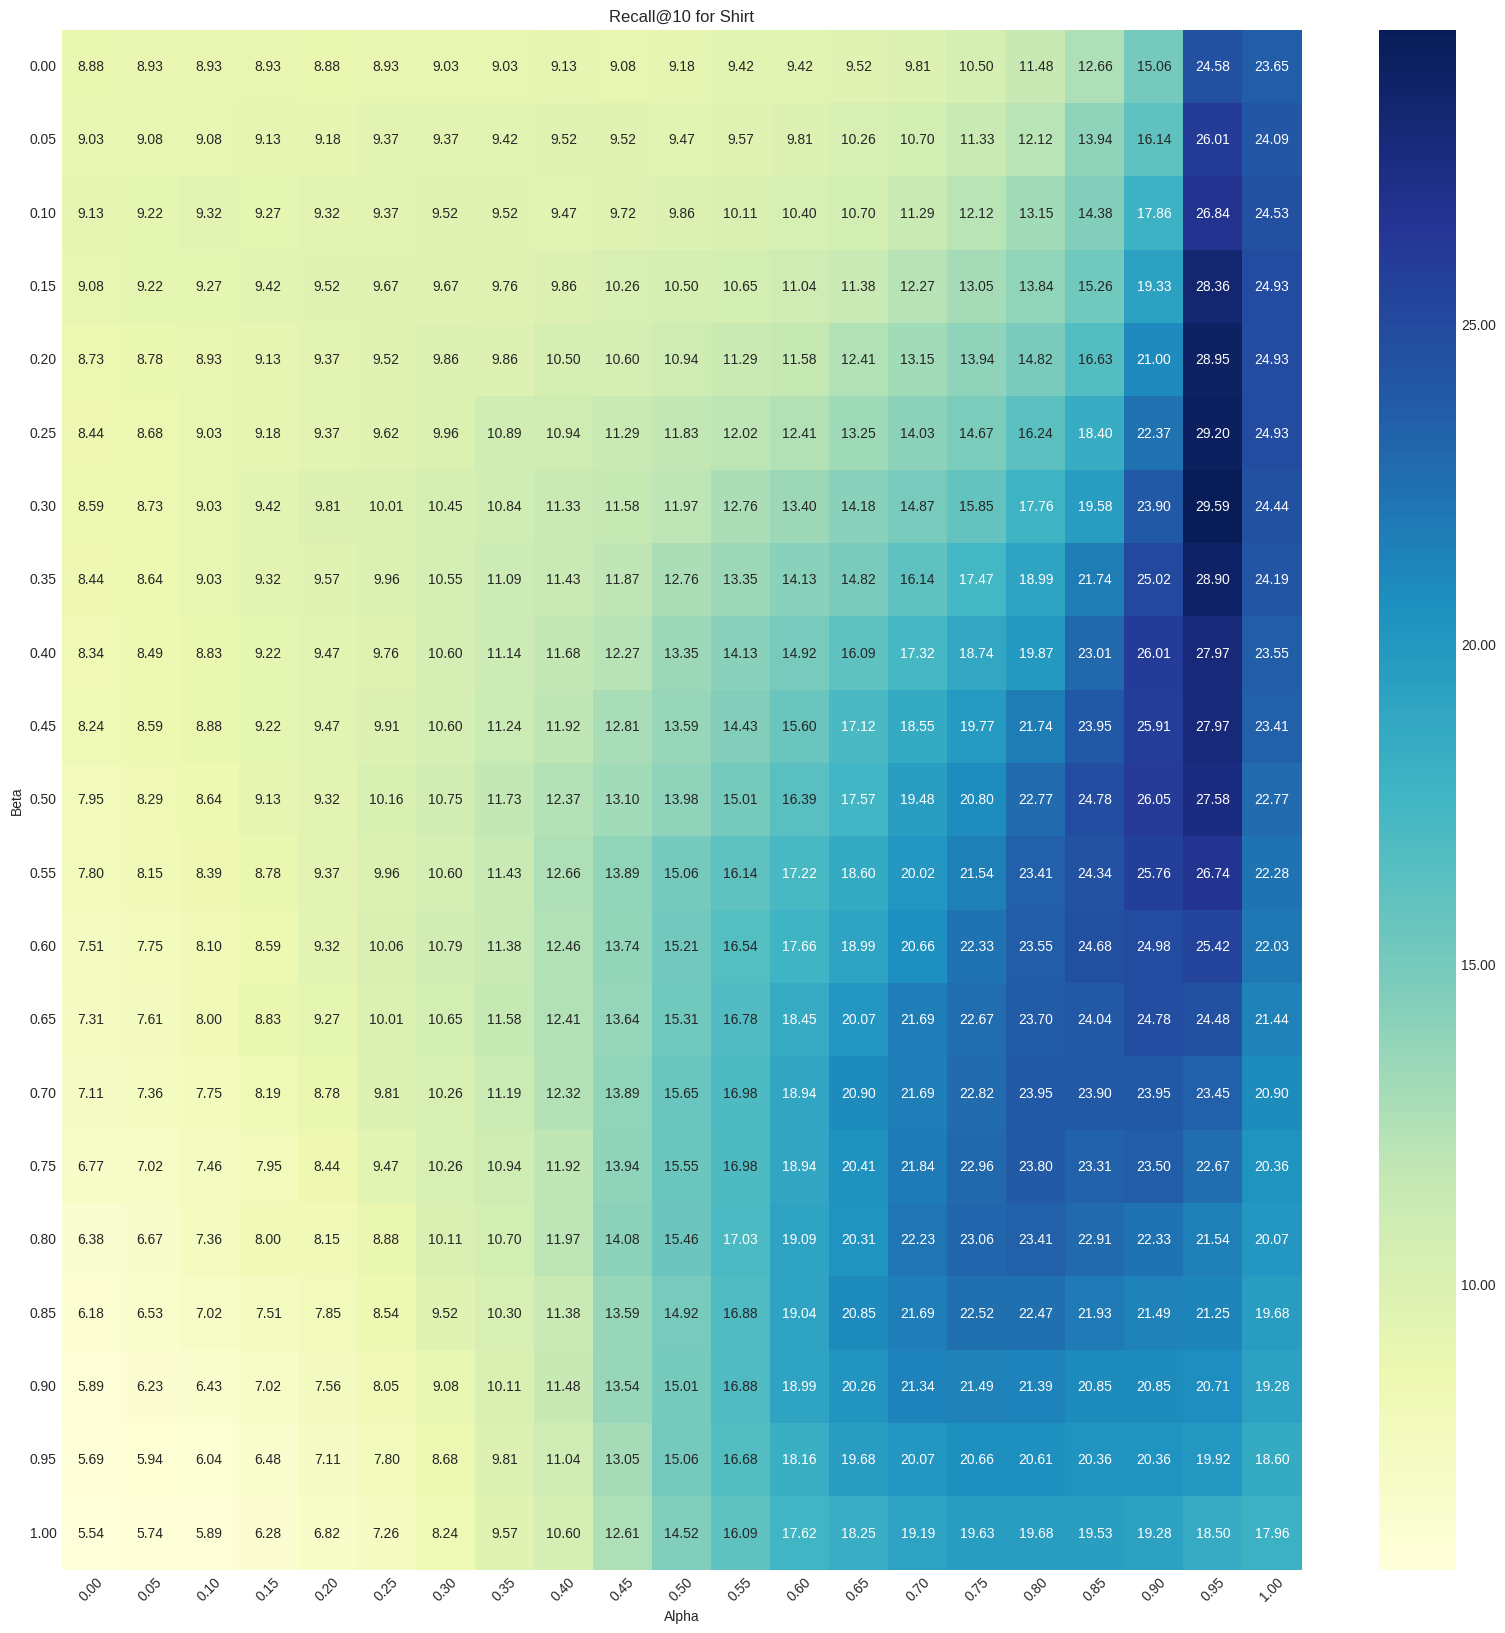

In [22]:
prepare_and_plot_recall_pivot(shirt_recall_at10, "Recall@10 for Shirt")

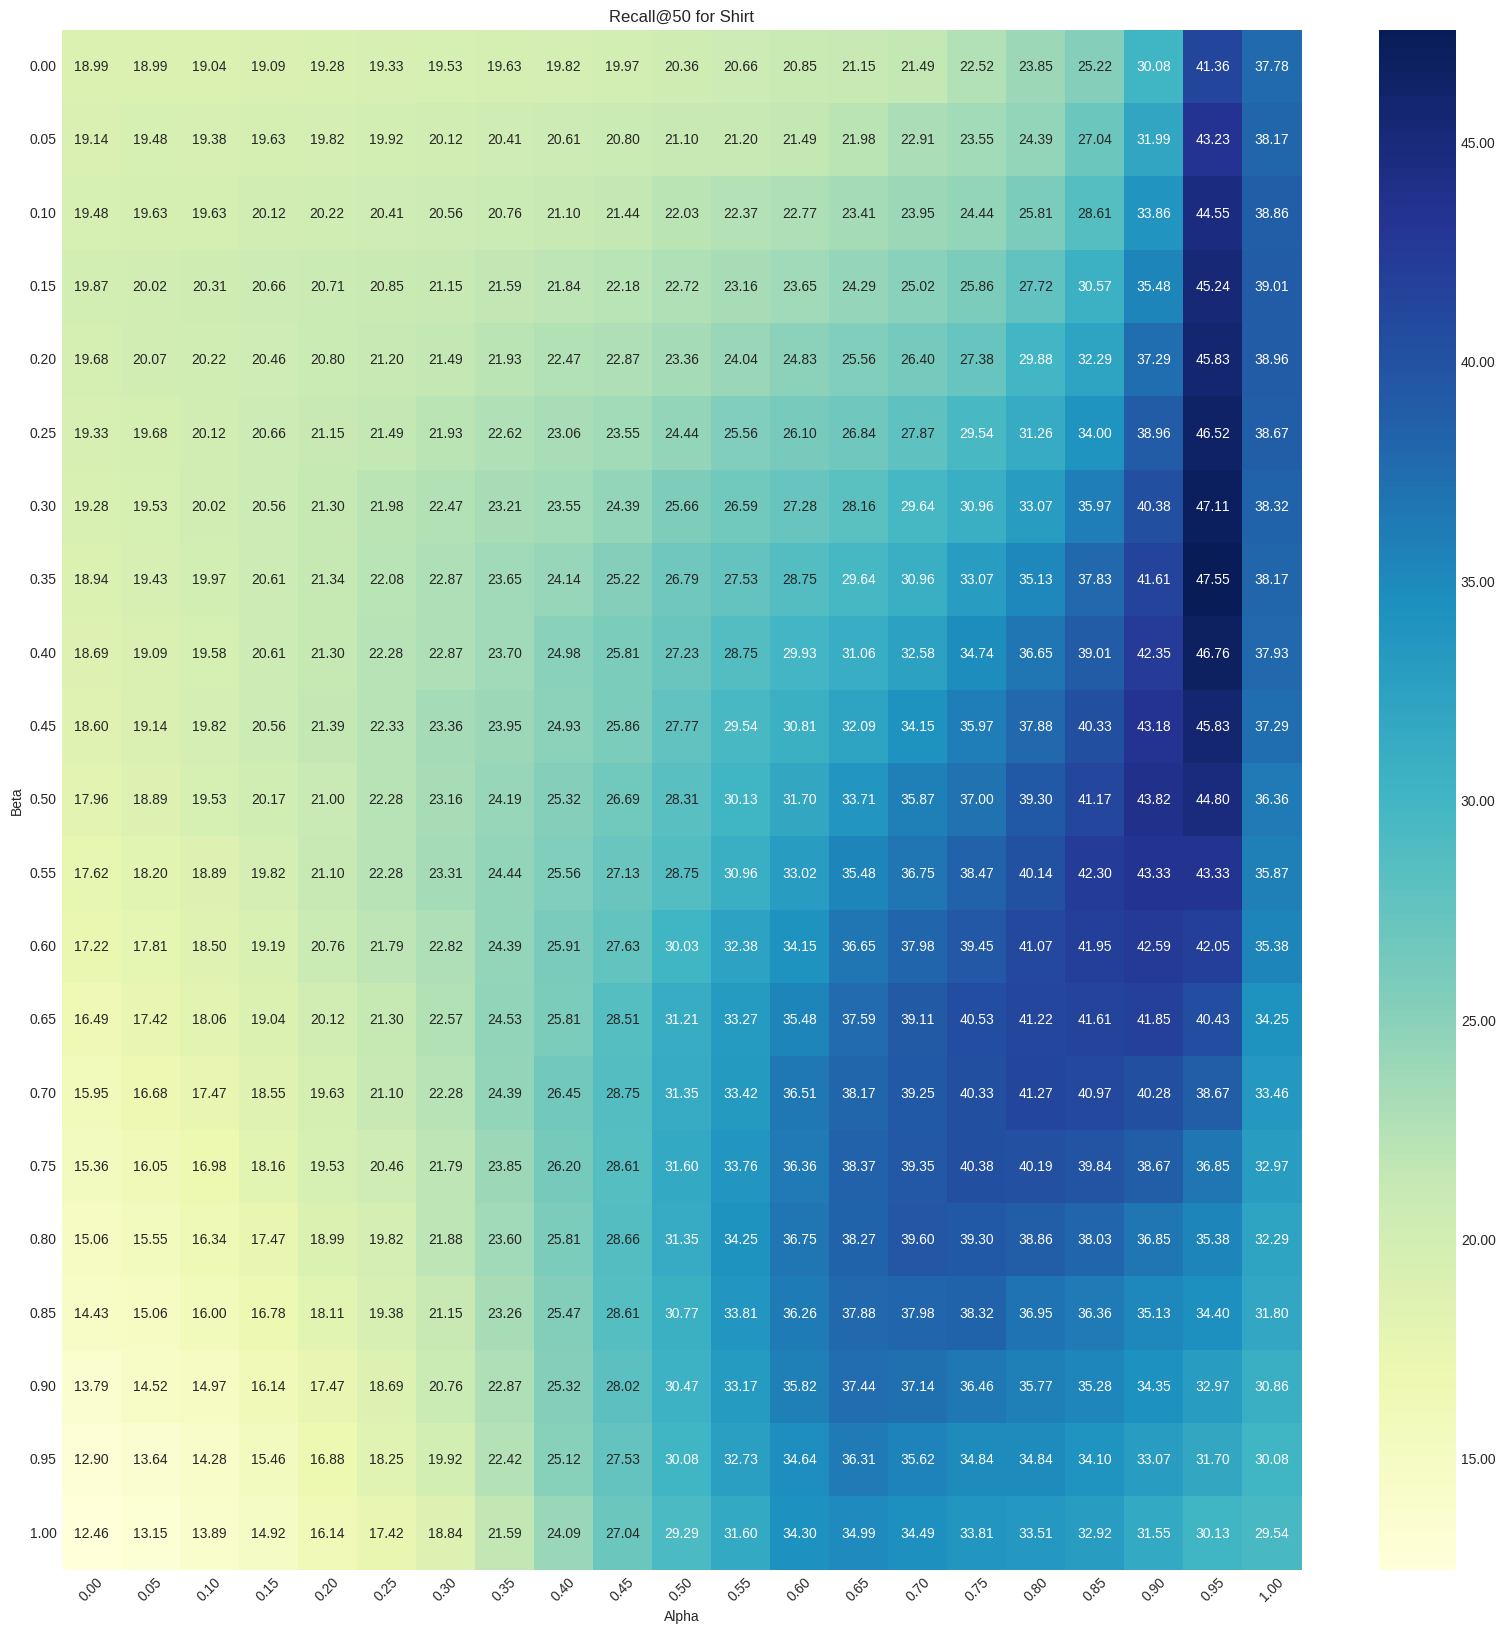

In [23]:
prepare_and_plot_recall_pivot(shirt_recall_at50, "Recall@50 for Shirt")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for Dress</div>

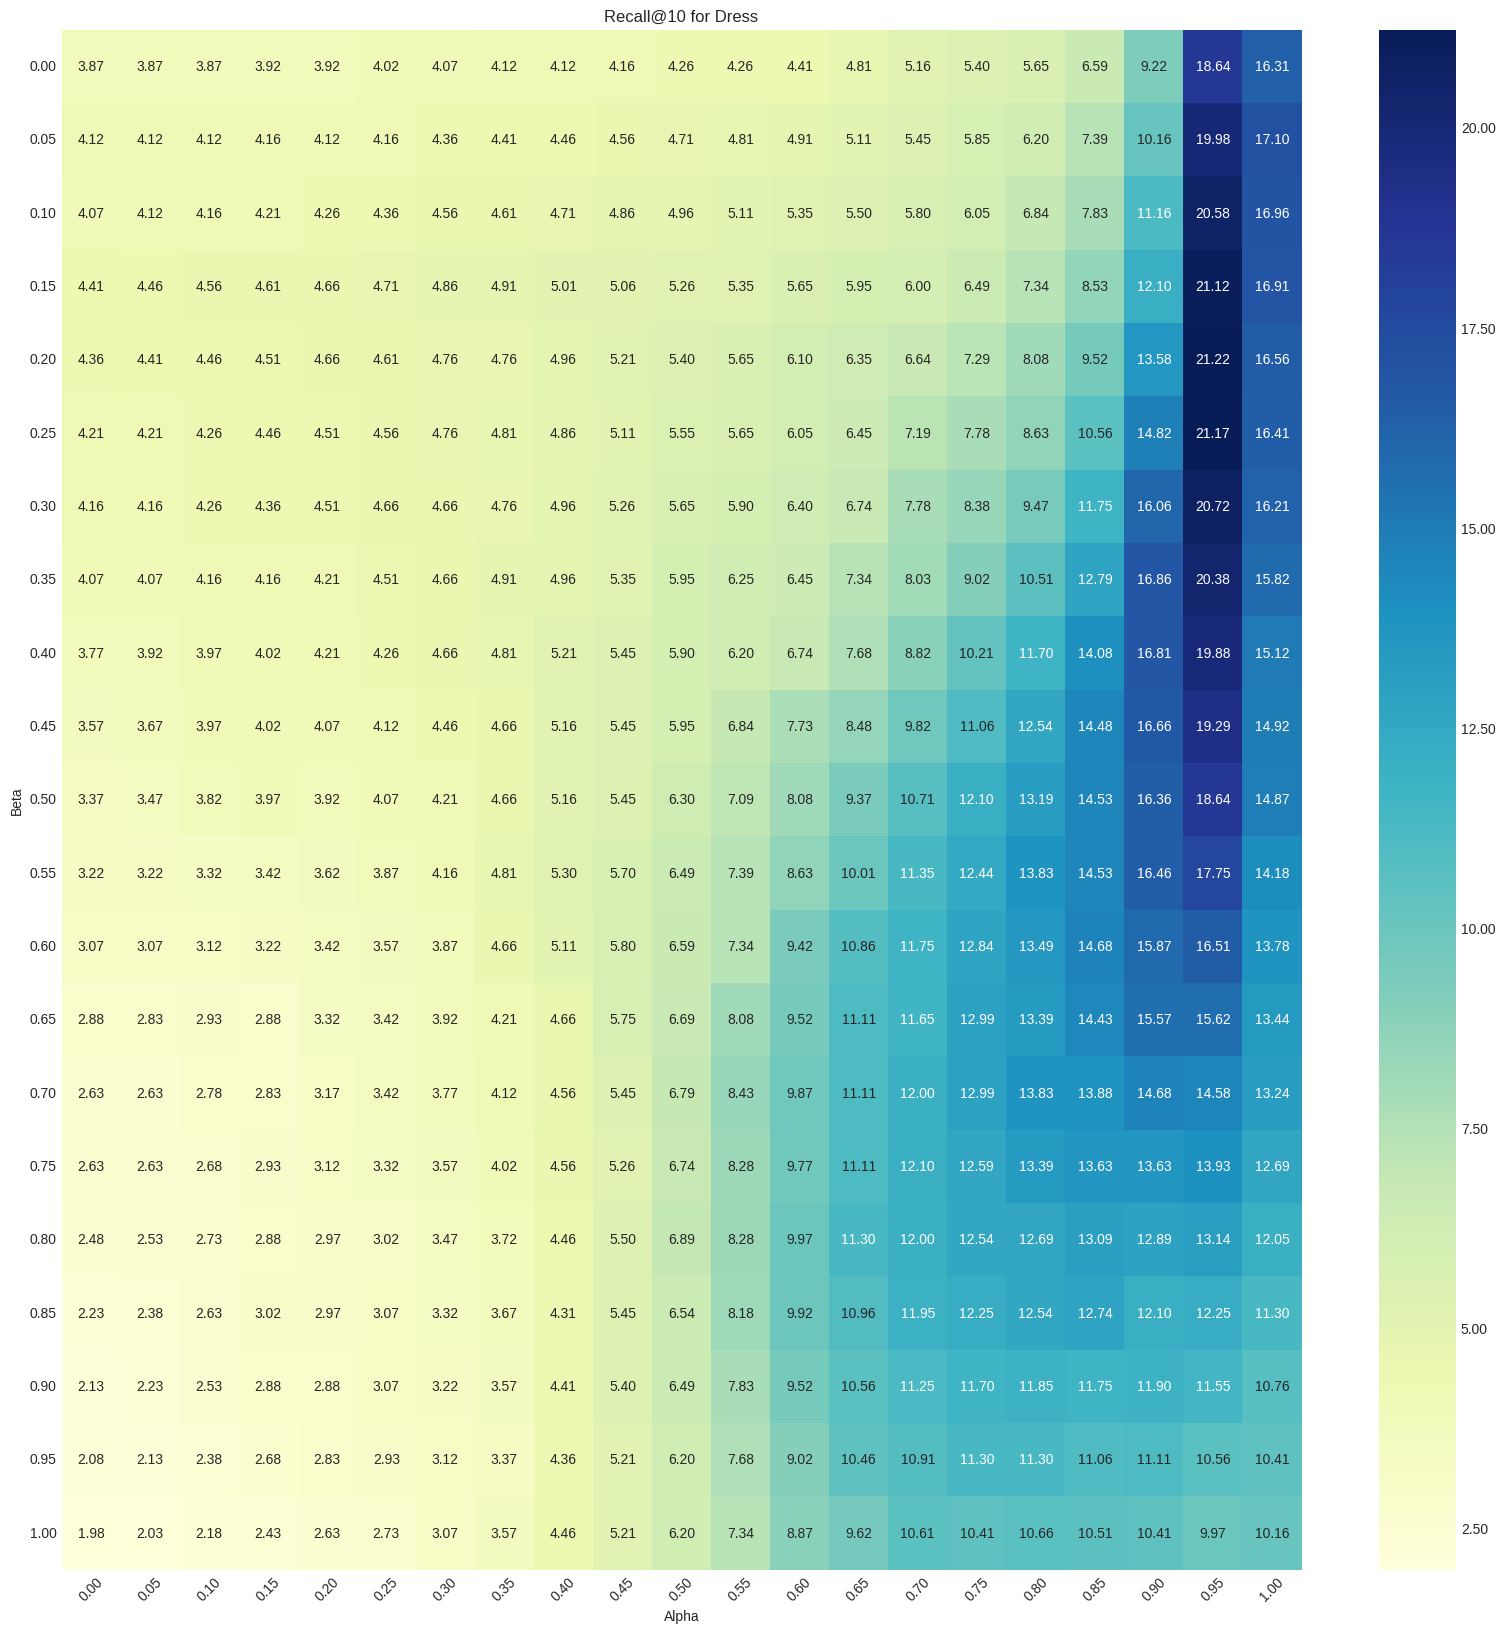

In [24]:
prepare_and_plot_recall_pivot(dress_recall_at10, "Recall@10 for Dress")

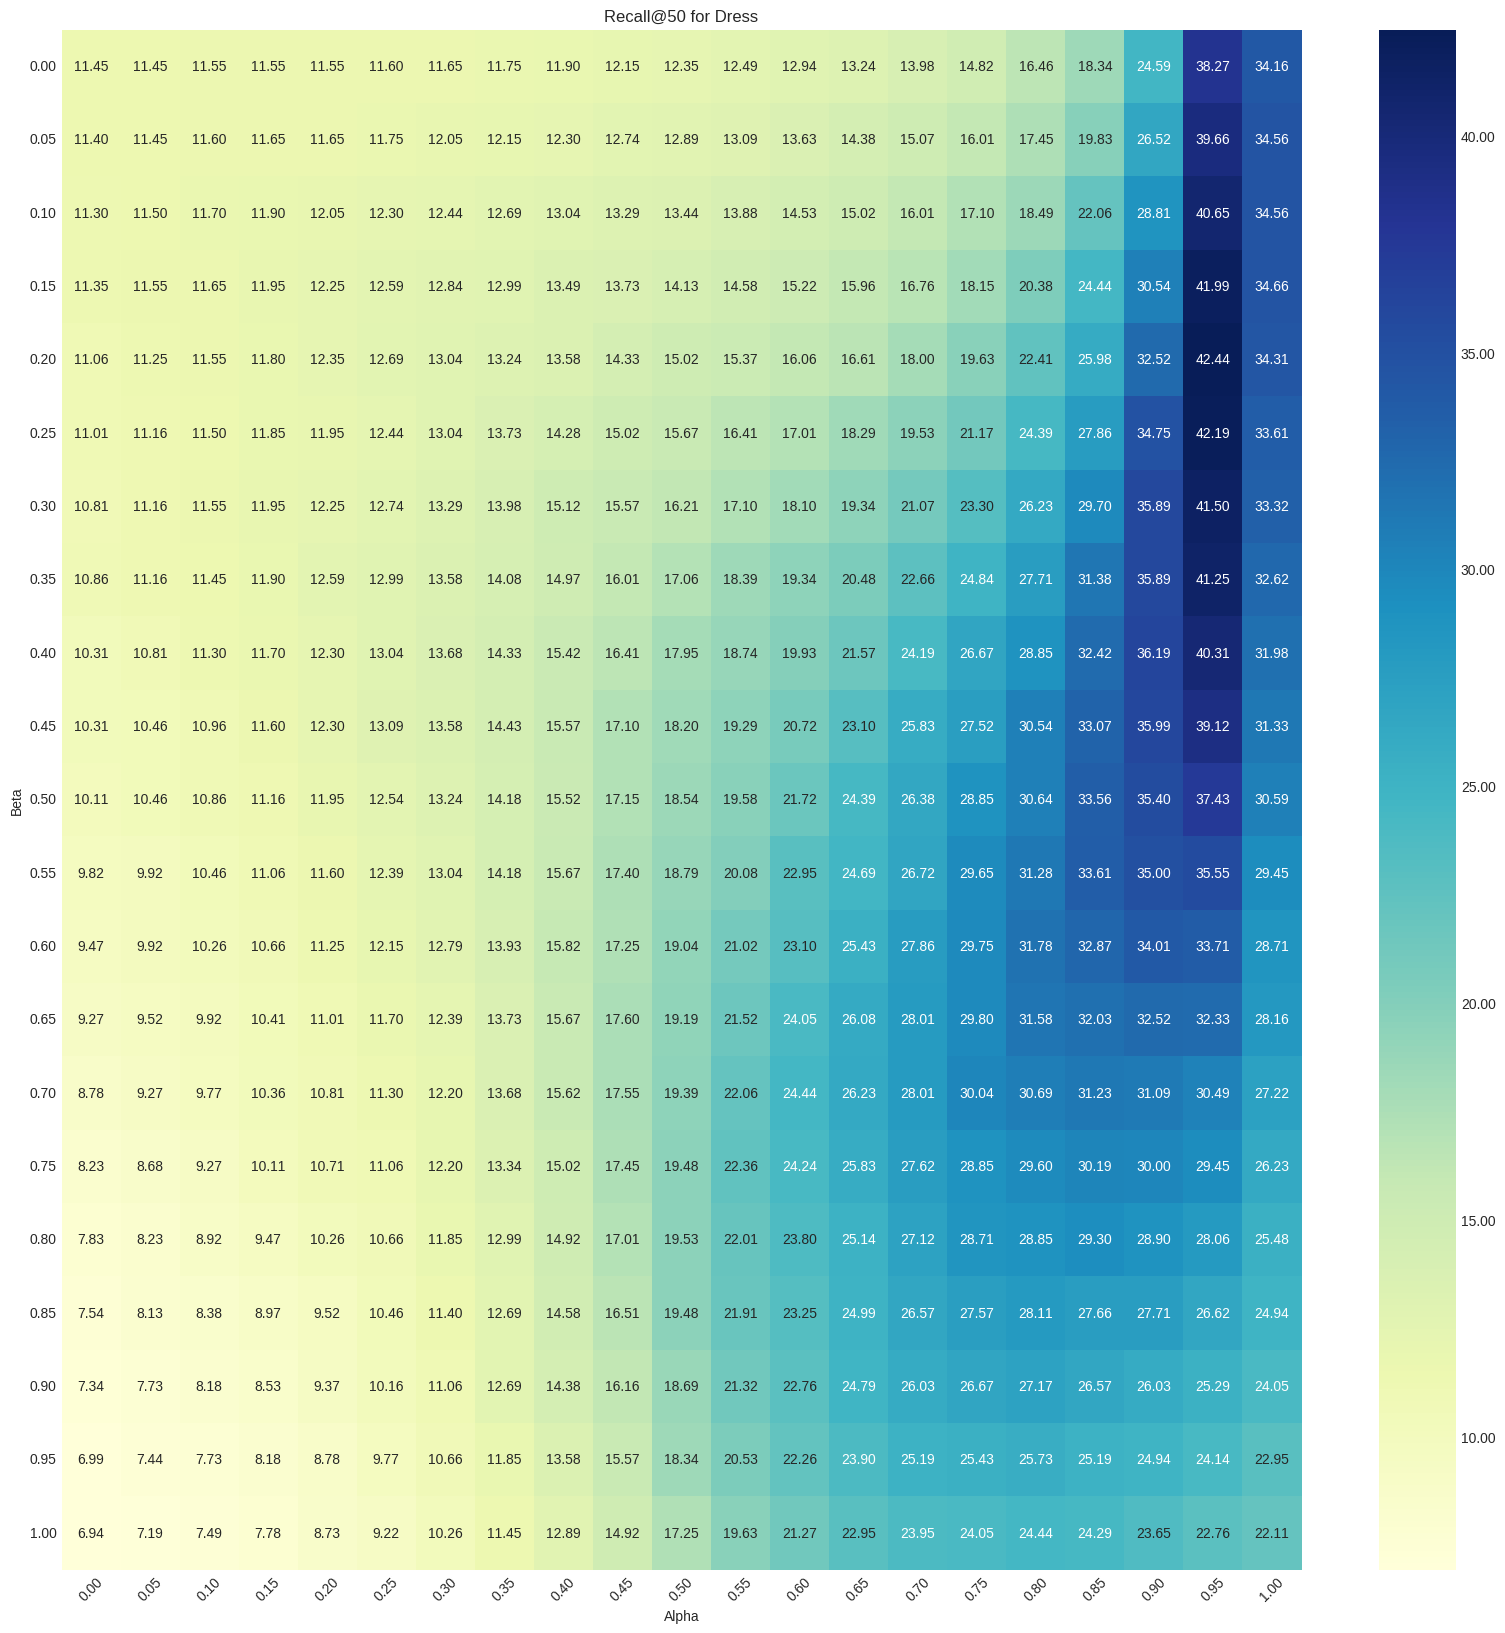

In [25]:
prepare_and_plot_recall_pivot(dress_recall_at50, "Recall@50 for Dress")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for TopTee</div>

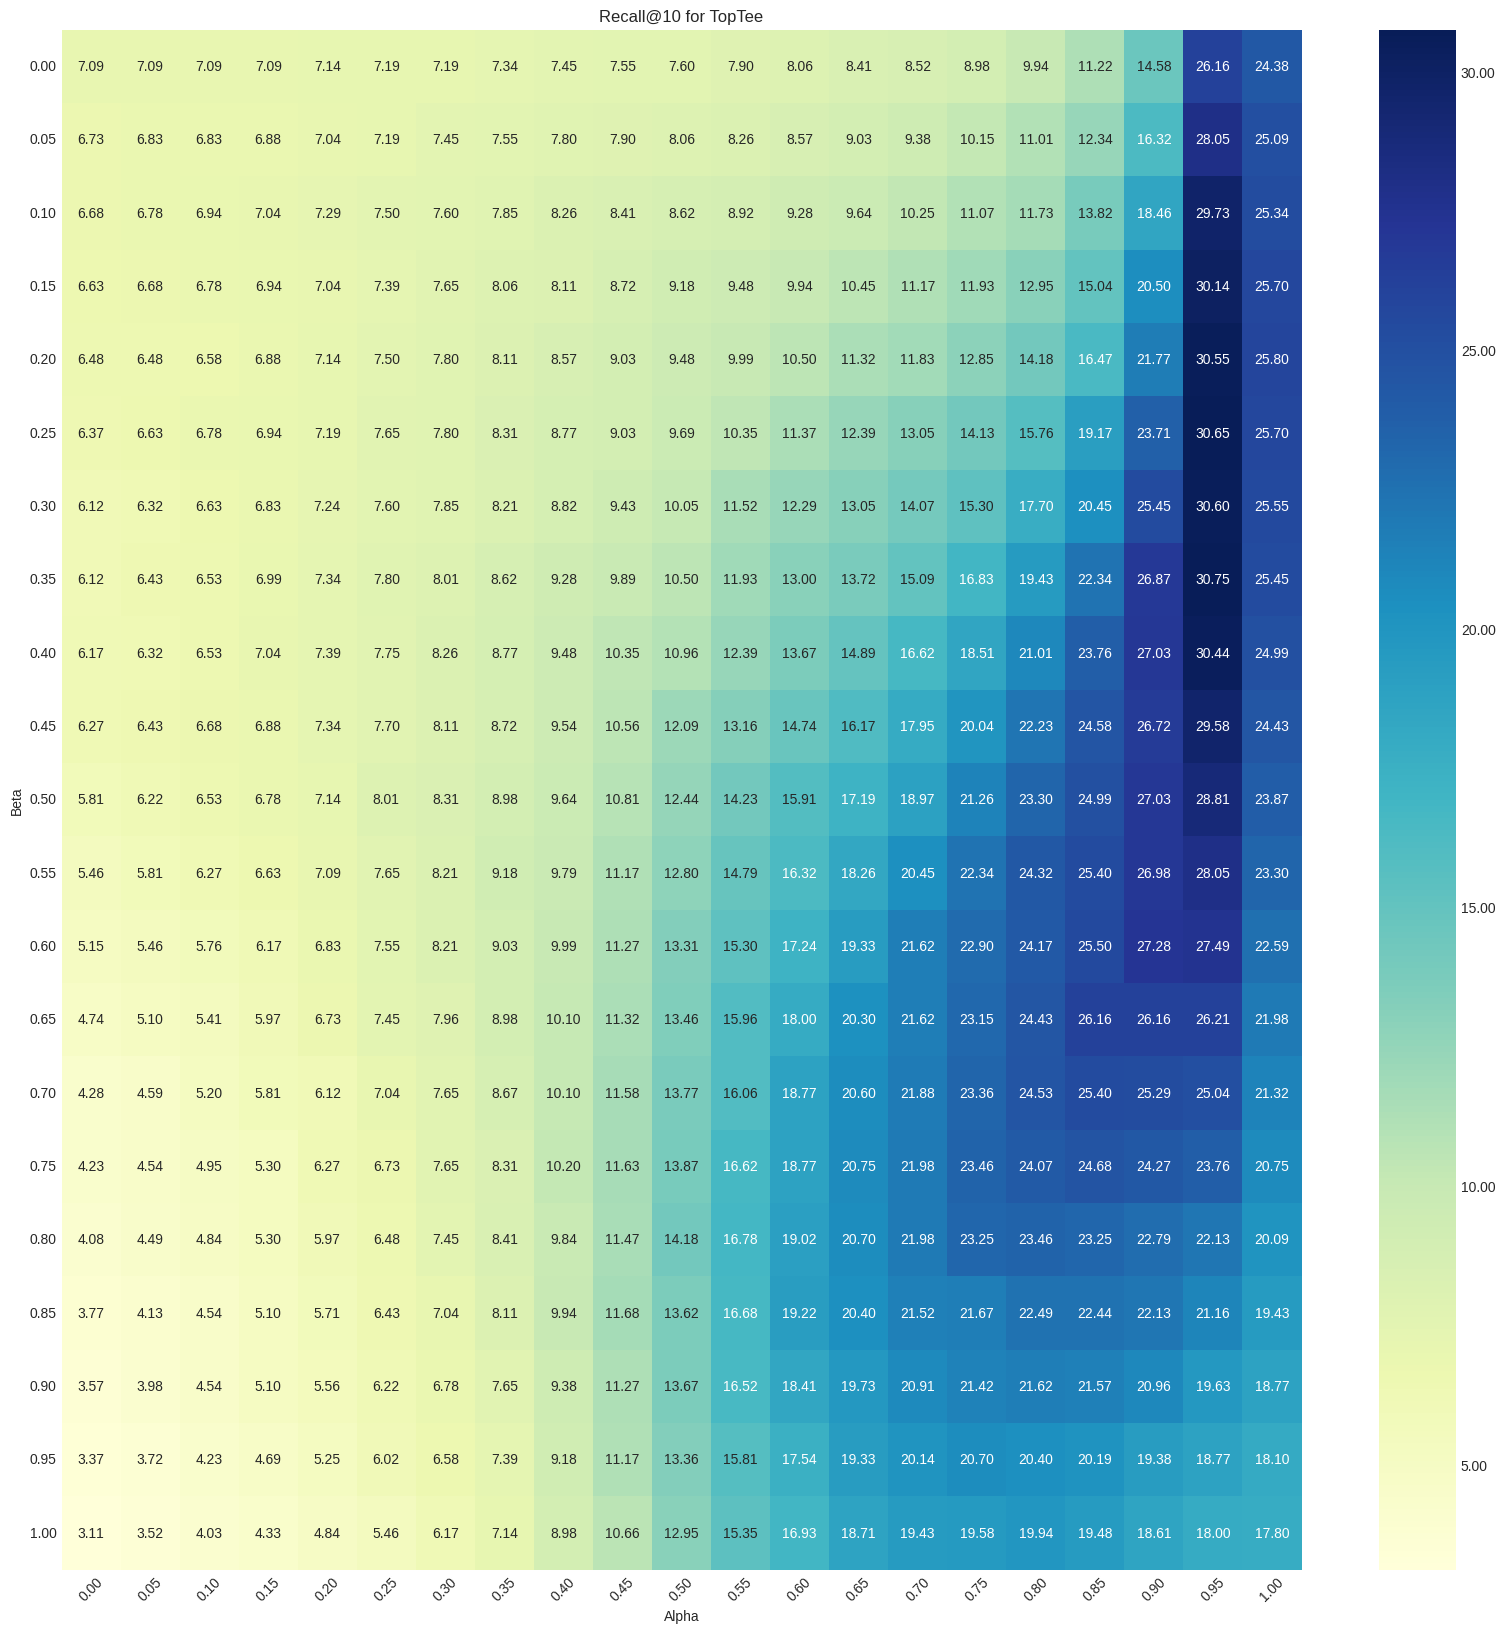

In [26]:
prepare_and_plot_recall_pivot(toptee_recall_at10, "Recall@10 for TopTee")

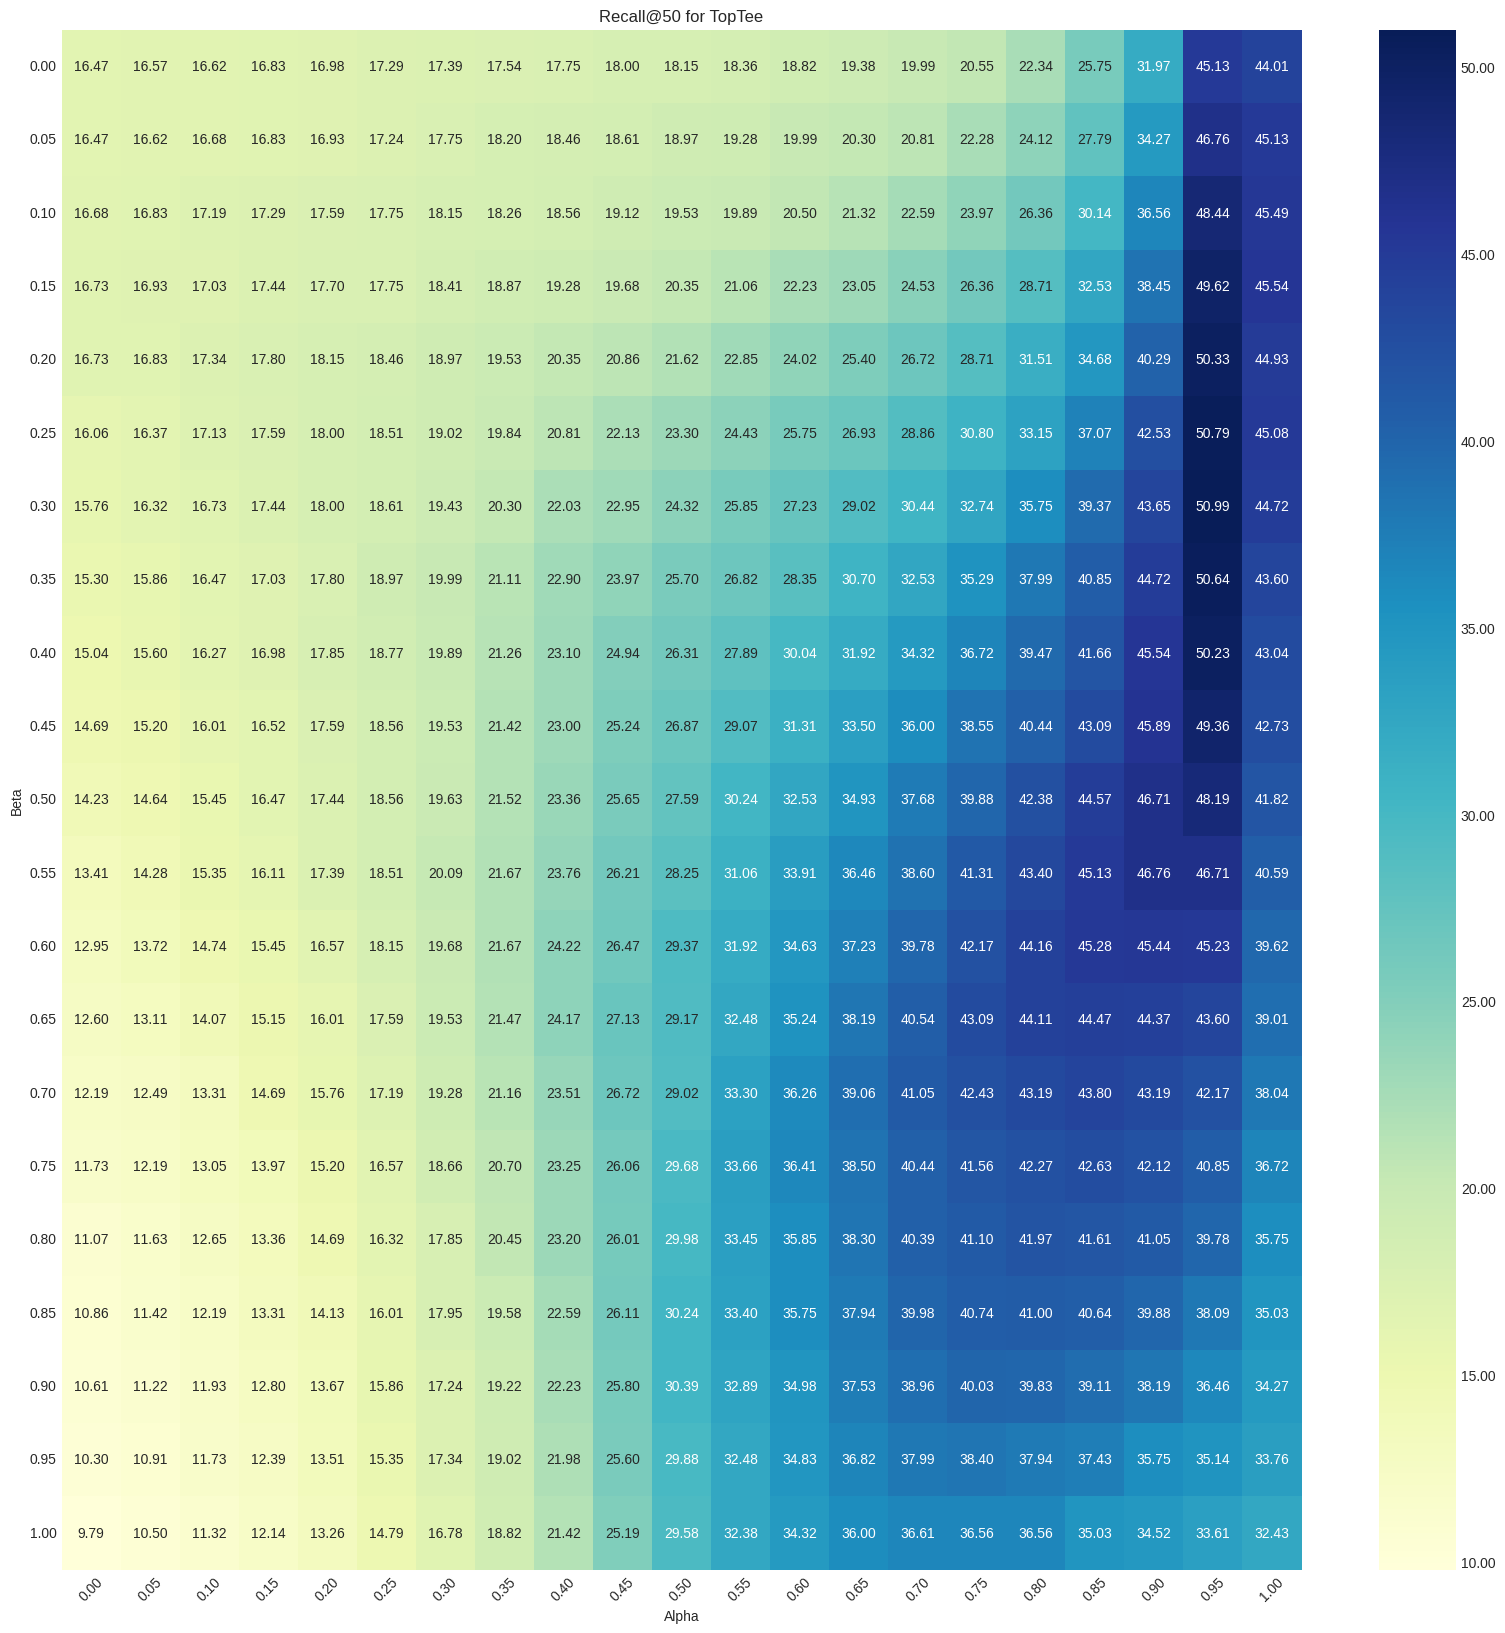

In [27]:
prepare_and_plot_recall_pivot(toptee_recall_at50, "Recall@50 for TopTee")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the average recall at 10 and 50 for all categories</div>

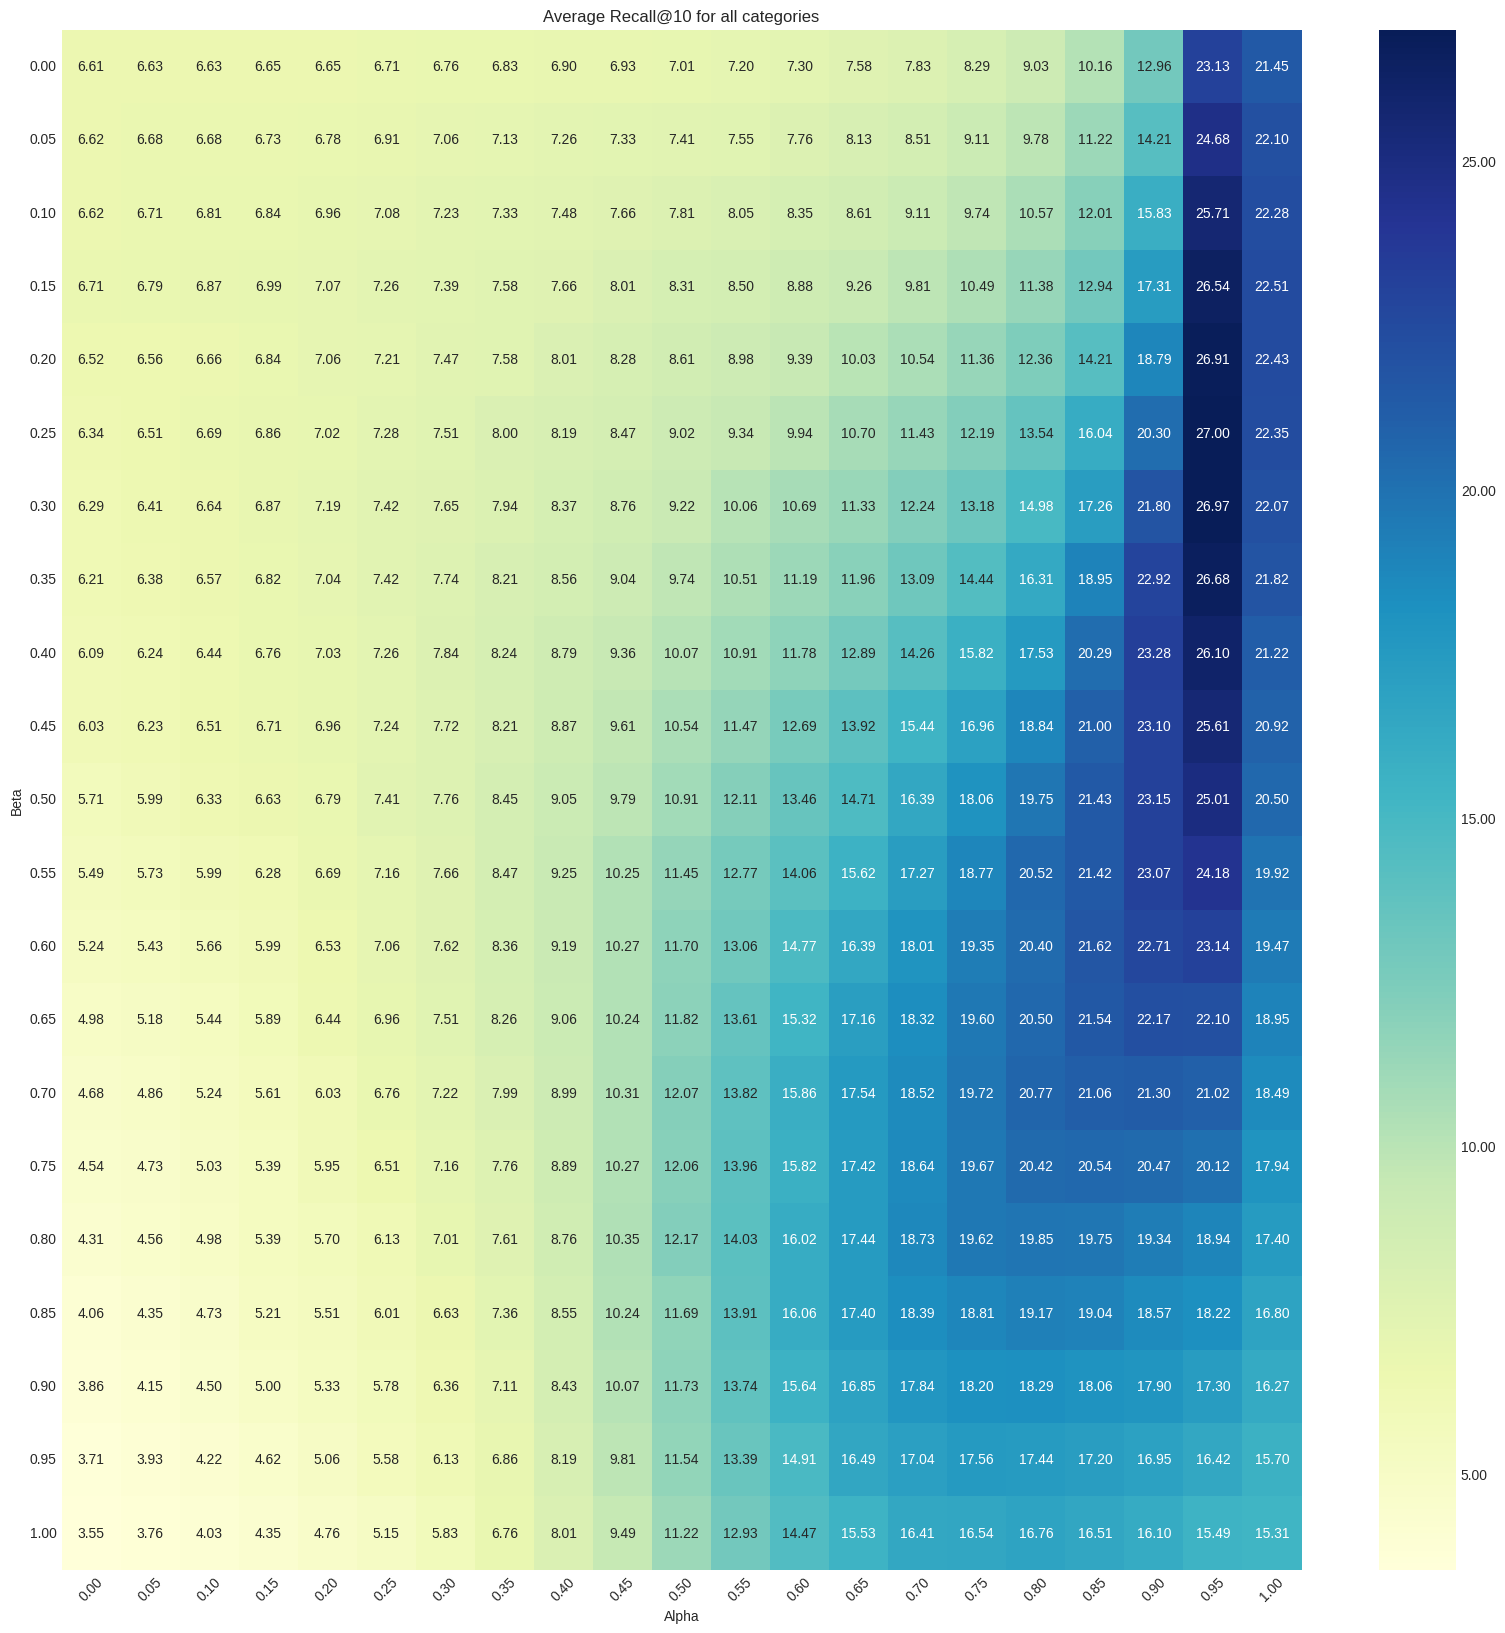

In [28]:
prepare_and_plot_recall_pivot(average_recall_at10, "Average Recall@10 for all categories")

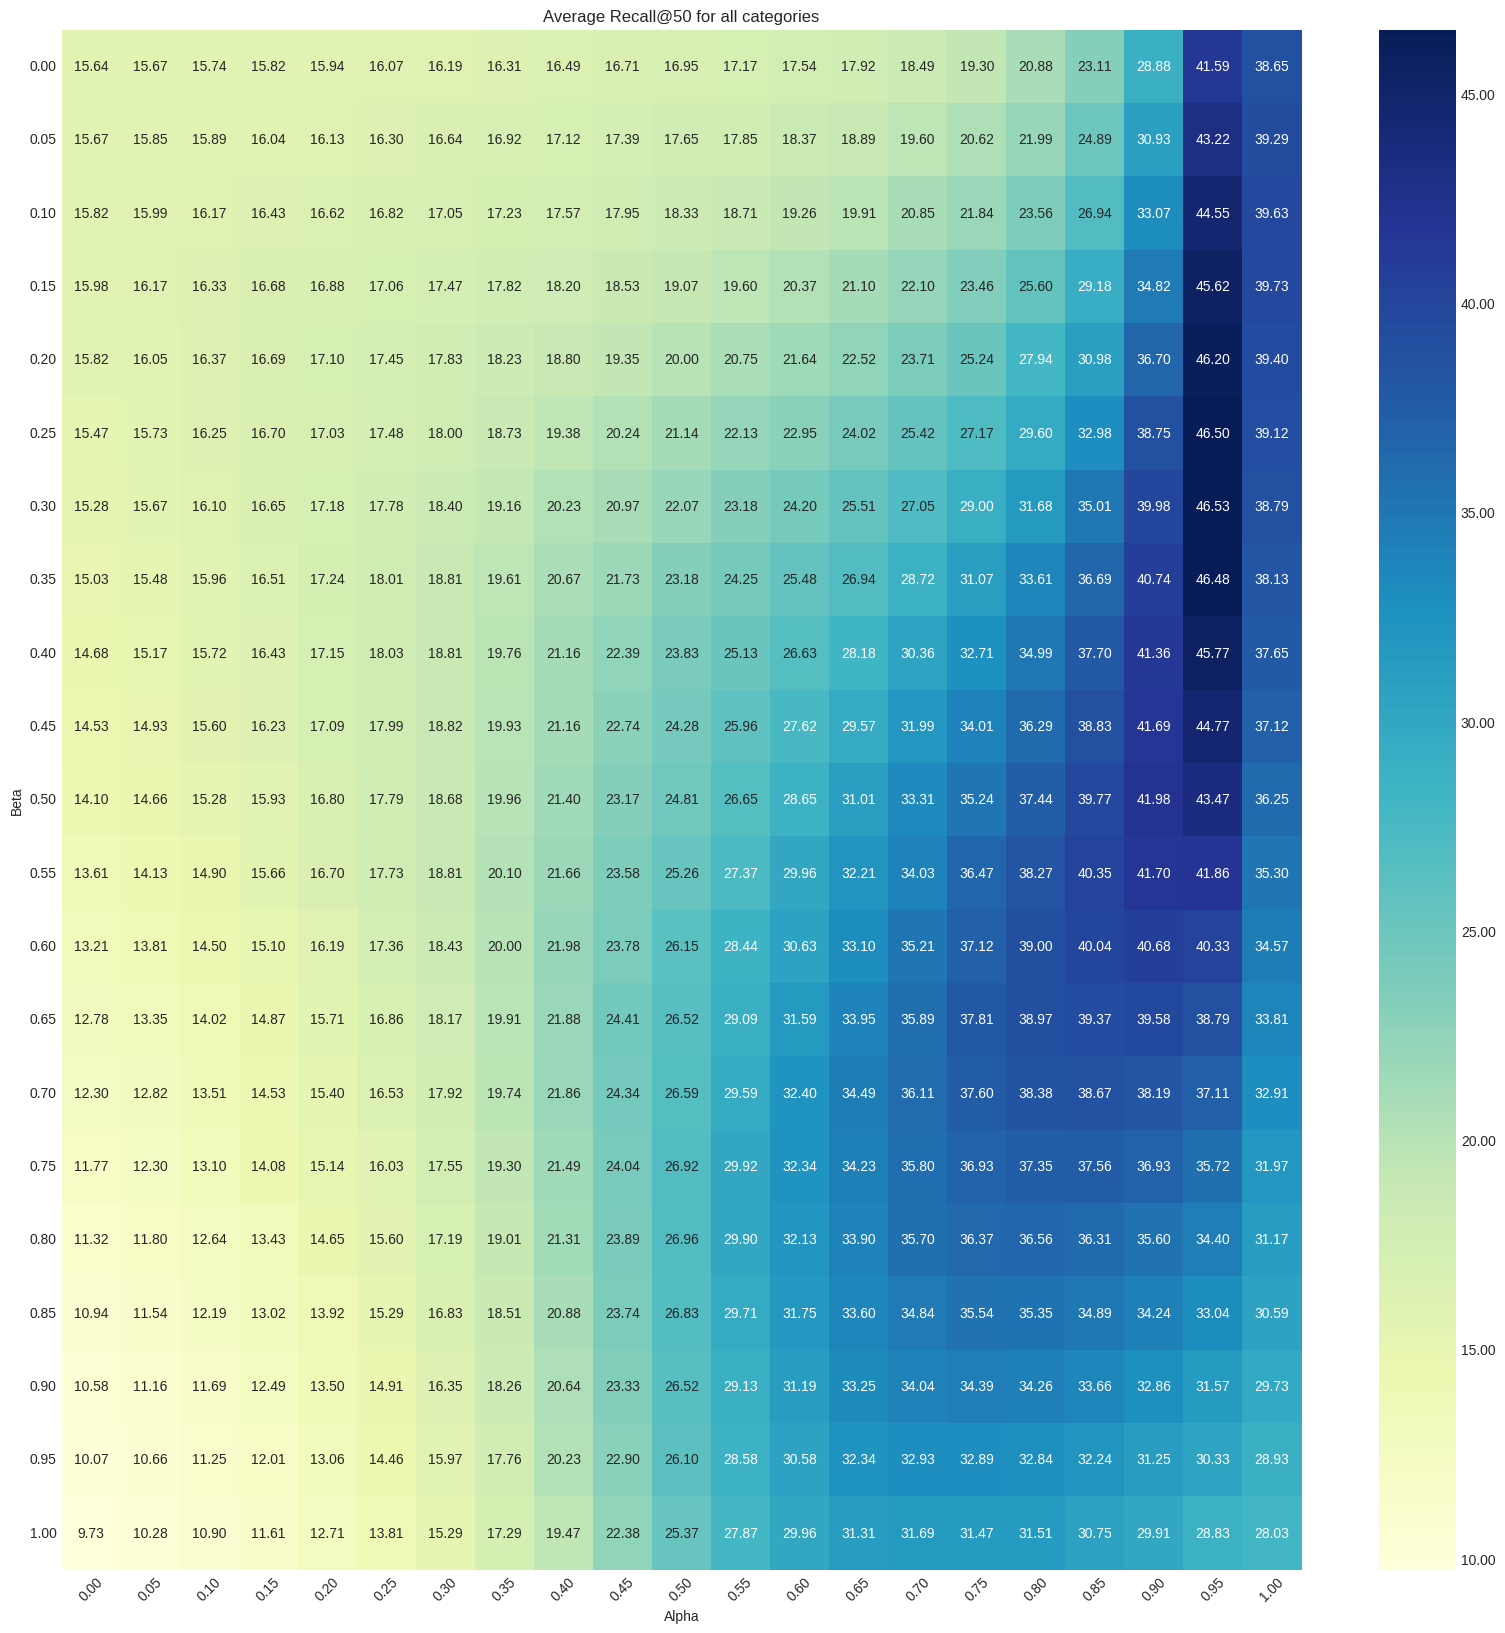

In [29]:
prepare_and_plot_recall_pivot(average_recall_at50, "Average Recall@50 for all categories")

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 5: View some sample of the result</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Shirt category</div>

In [30]:
sorted_indices_shirt, image_index_names_shirt, target_names_shirt = compute_results_fiq_val(
    'shirt',
    get_combing_function_with_alpha(0.95),
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0.2,
    cache=cache,
)

Recall at 10: 28.949952125549316
Recall at 50: 45.82924544811249


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Dress category</div>

In [31]:
sorted_indices_dress, image_index_names_dress, target_names_dress = compute_results_fiq_val(
    'dress',
    get_combing_function_with_alpha(0.95),
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0.2,
    cache=cache,
)

Recall at 10: 21.219633519649506
Recall at 50: 42.43926703929901


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the TopTee category</div>

In [32]:
sorted_indices_toptee, image_index_names_toptee, target_names_toptee = compute_results_fiq_val(
    'toptee',
    get_combing_function_with_alpha(0.95),
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0.2,
    cache=cache,
)

Recall at 10: 30.545639991760254
Recall at 50: 50.33146142959595


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Prepare the ground truth data</div>

In [33]:
ground_truth_dress = prepare_ground_truths(json.load(open('../../../fashionIQ_dataset/captions/cap.dress.val.json')))
ground_truth_shirt = prepare_ground_truths(json.load(open('../../../fashionIQ_dataset/captions/cap.shirt.val.json')))
ground_truth_toptee = prepare_ground_truths(json.load(open('../../../fashionIQ_dataset/captions/cap.toptee.val.json')))

DATASET_IMAGE_DIR = '../../../fashionIQ_dataset/images/'

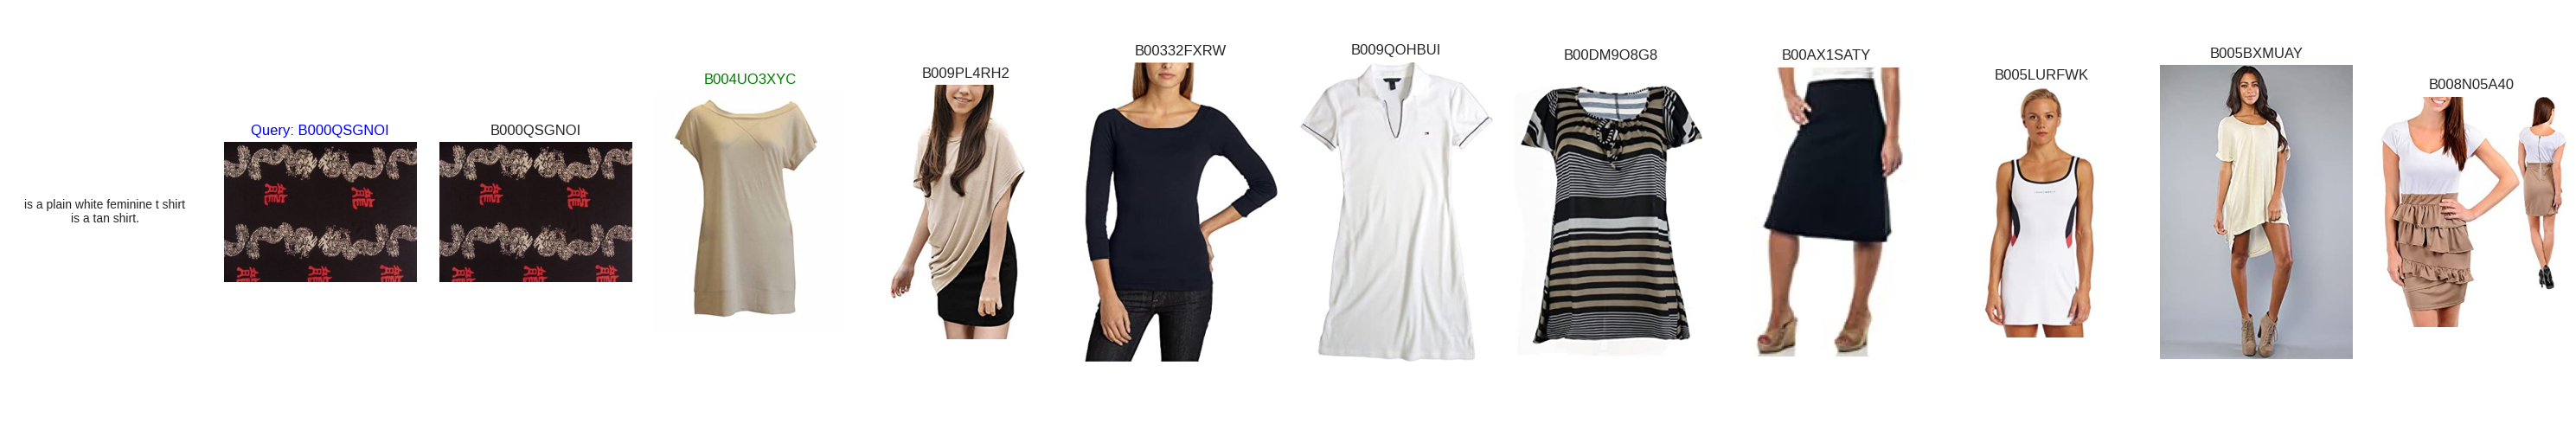

In [34]:
plot_retrieval_results_of_i(
    sorted_indices_dress, 
    image_index_names_dress, 
    target_names_dress, 
    ground_truth_dress, 
    top_k=10, 
    i=3,
    directory=DATASET_IMAGE_DIR,
)

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 6: Compare with the original without MMLM captions and identical weights element-wise sum</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Shirt category</div>

In [35]:
sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin = compute_results_fiq_val(
    'shirt',
    combining_function_original,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0,
    cache=cache,
)

Recall at 10: 9.175662696361542
Recall at 50: 20.363101363182068


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Dress category</div>

In [36]:
sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin = compute_results_fiq_val(
    'dress',
    combining_function_original,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0,
    cache=cache,
)

Recall at 10: 4.263757914304733
Recall at 50: 12.345066666603088


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the TopTee category</div>

In [37]:
sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin = compute_results_fiq_val(
    'toptee',
    combining_function_original,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    beta=0,
    cache=cache,
)

Recall at 10: 7.598163932561874
Recall at 50: 18.154002726078033


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the Shirt category</div>

In [38]:
become_better = found_better_than_original(
    sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin,
    sorted_indices_shirt, image_index_names_shirt, target_names_shirt,
    top_k=10
)

len(become_better), become_better[:10]

(434, [1, 6, 8, 11, 13, 19, 34, 37, 40, 44])

In [39]:
become_worse = found_better_than_original(
    sorted_indices_shirt, image_index_names_shirt, target_names_shirt,
    sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(23, [183, 263, 281, 376, 463, 628, 640, 754, 806, 880])

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the Dress category</div>

In [40]:
become_better = found_better_than_original(
    sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin,
    sorted_indices_dress, image_index_names_dress, target_names_dress,
    top_k=10
)

len(become_better), become_better[:10]

(371, [1, 3, 12, 16, 19, 27, 33, 34, 36, 38])

In [41]:
become_worse = found_better_than_original(
    sorted_indices_dress, image_index_names_dress, target_names_dress,
    sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(20, [109, 125, 218, 496, 605, 618, 706, 726, 760, 930])

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the TopTee category</div>

In [42]:
become_better = found_better_than_original(
    sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin,
    sorted_indices_toptee, image_index_names_toptee, target_names_toptee,
    top_k=10
)

len(become_better), become_better[:10]

(487, [2, 3, 4, 7, 9, 13, 15, 17, 20, 24])

In [43]:
become_worse = found_better_than_original(
    sorted_indices_toptee, image_index_names_toptee, target_names_toptee,
    sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(24, [170, 216, 230, 369, 398, 492, 520, 677, 732, 770])

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 7: Visualize the comparison</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the Shirt category</div>

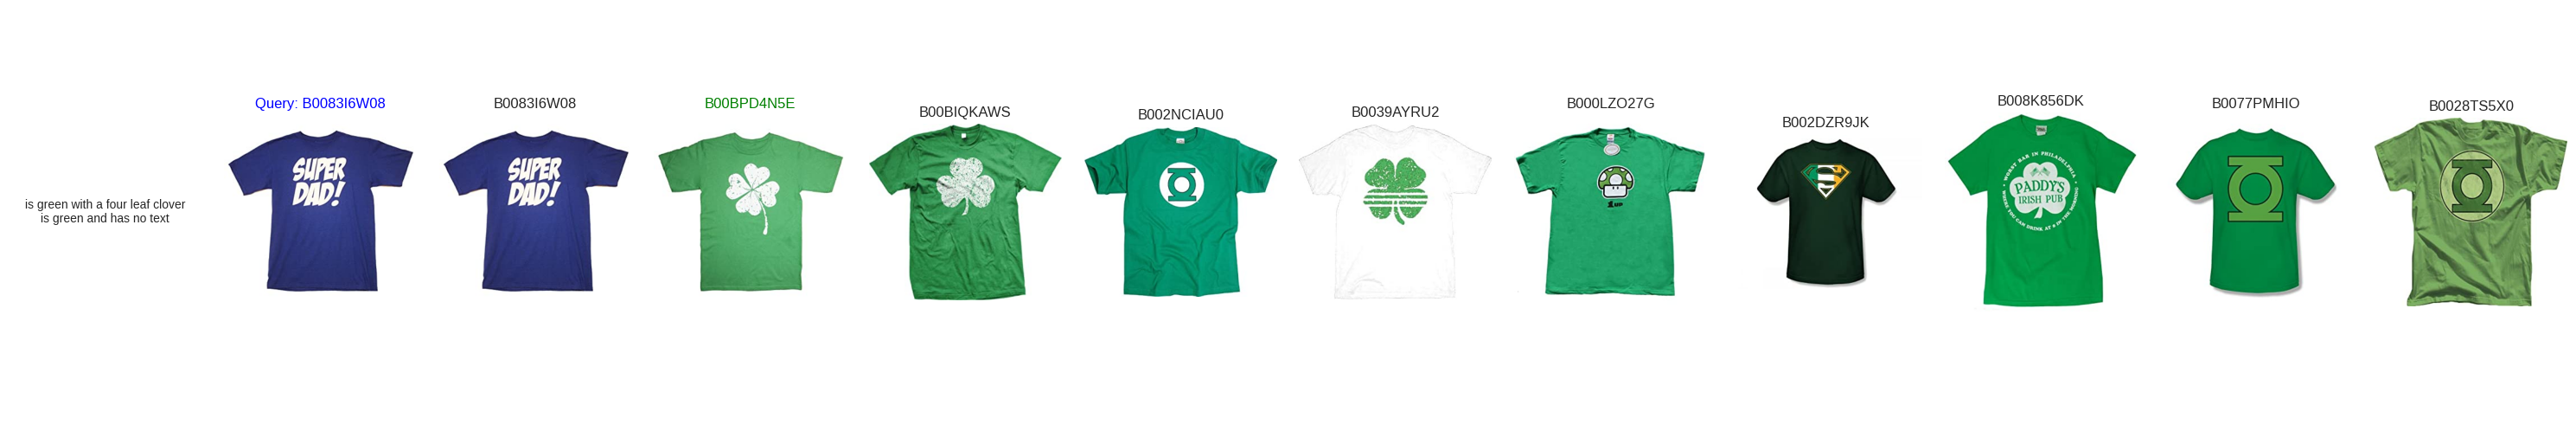

In [44]:
plot_retrieval_results_of_i(sorted_indices_shirt, image_index_names_shirt, target_names_shirt, ground_truth_shirt, top_k=10, i=1, directory=DATASET_IMAGE_DIR)

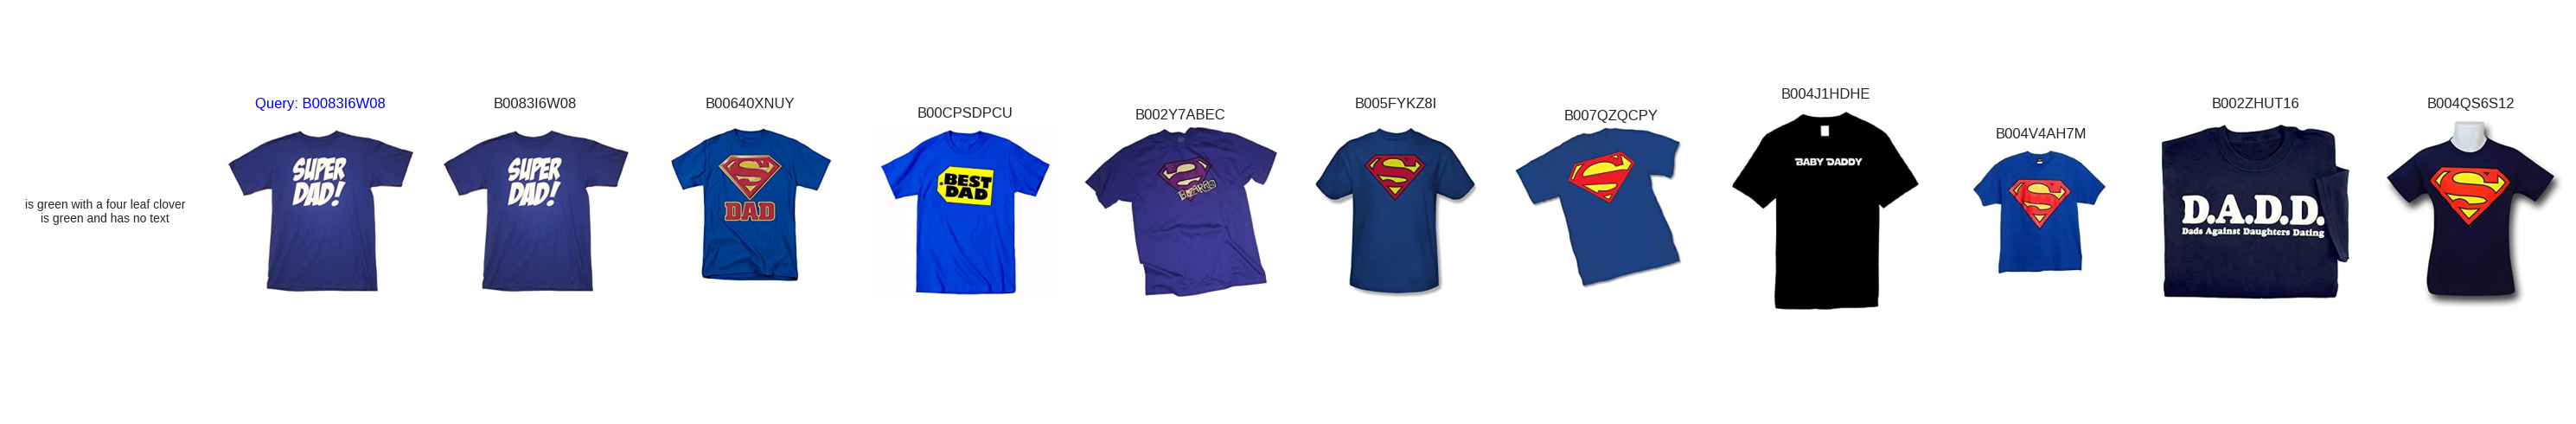

In [45]:
plot_retrieval_results_of_i(sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin, ground_truth_shirt, top_k=10, i=1, directory=DATASET_IMAGE_DIR)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the Dress category</div>

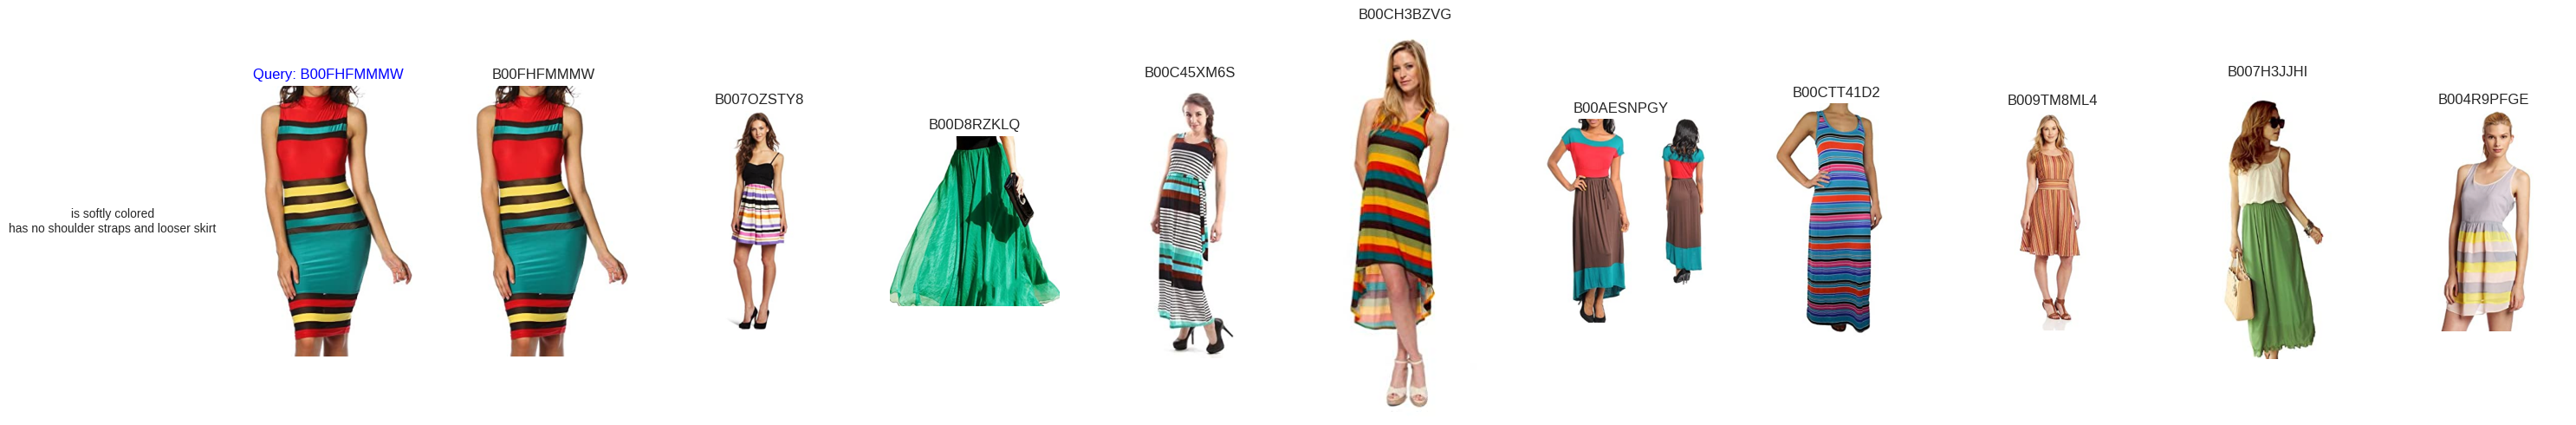

In [46]:
plot_retrieval_results_of_i(sorted_indices_dress, image_index_names_dress, target_names_dress, ground_truth_dress, top_k=10, i=11, directory=DATASET_IMAGE_DIR)

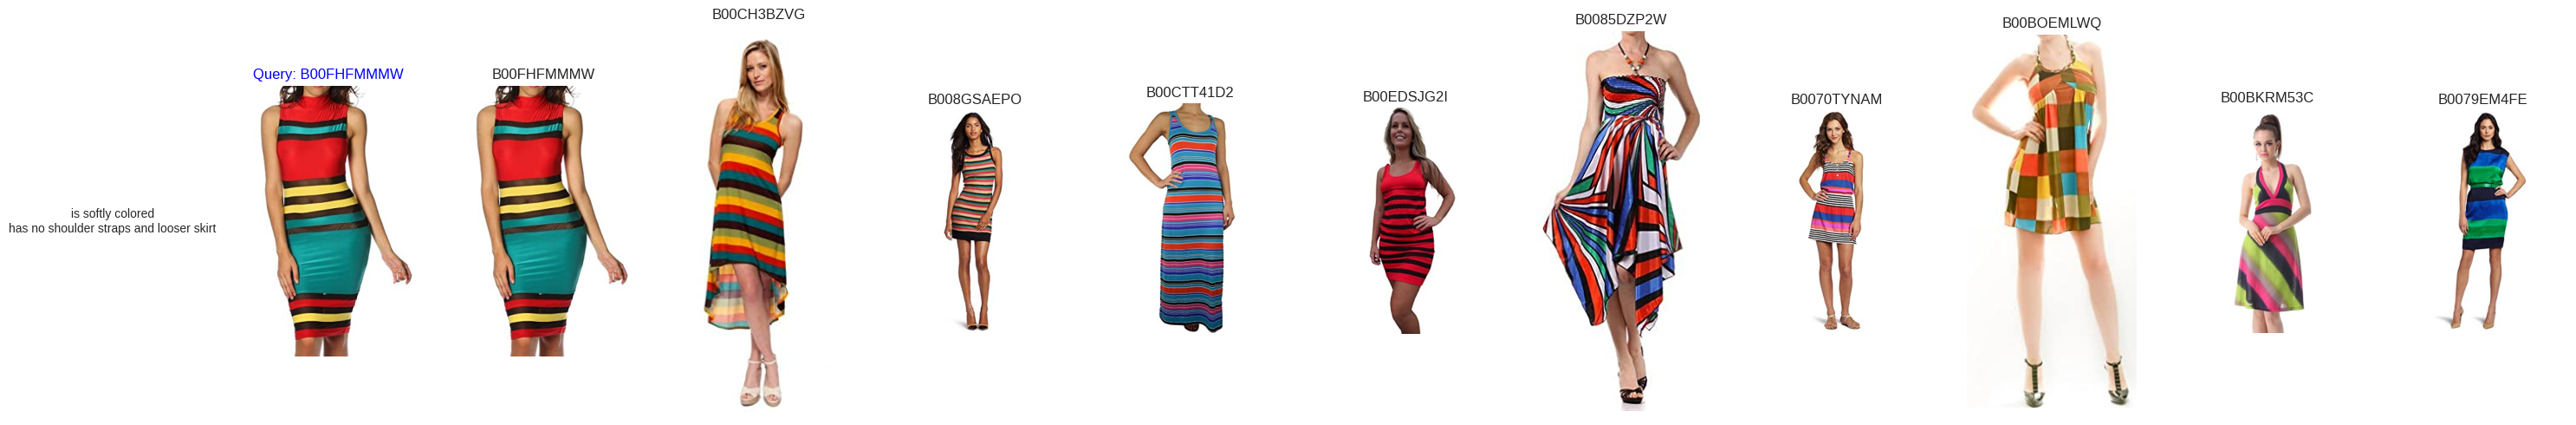

In [47]:
plot_retrieval_results_of_i(sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin, ground_truth_dress, top_k=10, i=11, directory=DATASET_IMAGE_DIR)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the TopTee category</div>

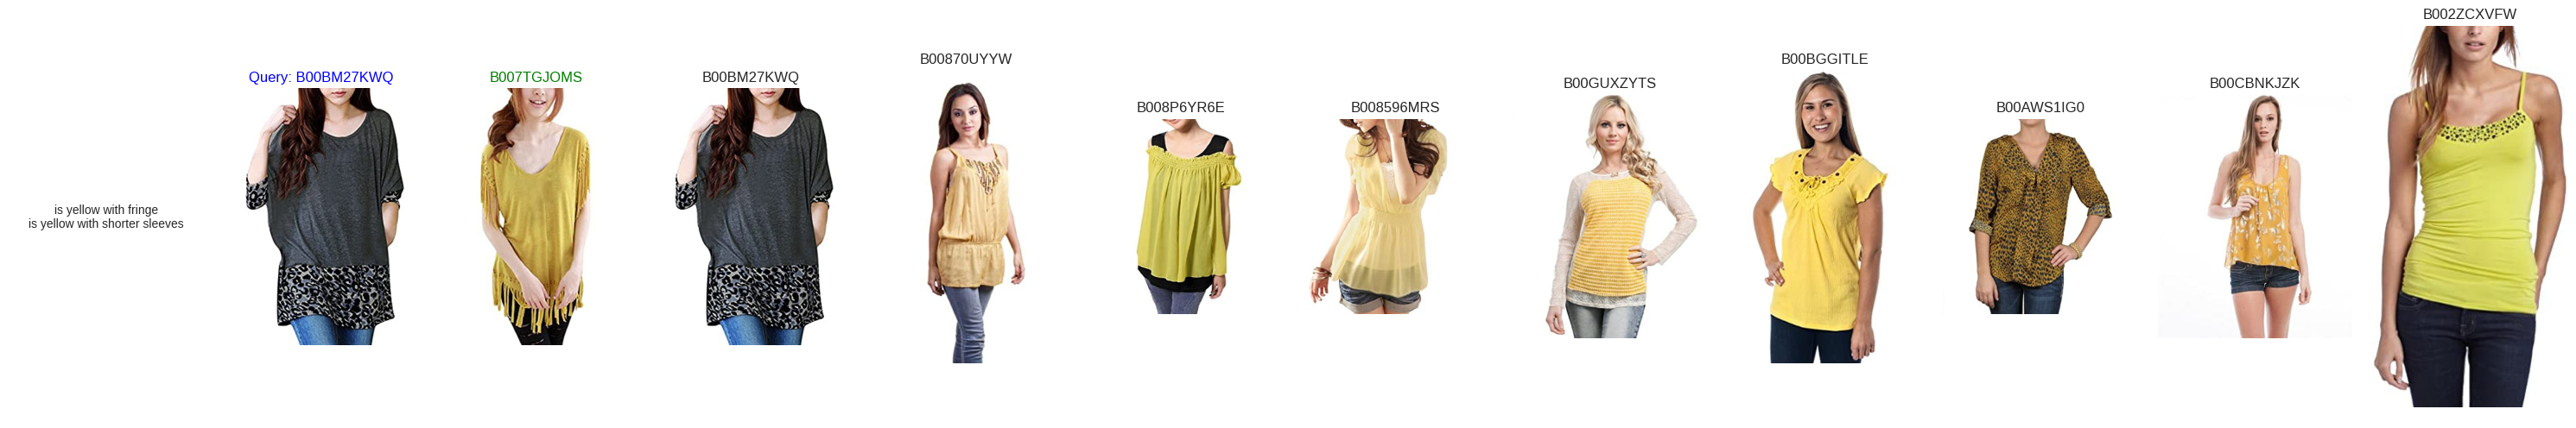

In [48]:
plot_retrieval_results_of_i(sorted_indices_toptee, image_index_names_toptee, target_names_toptee, ground_truth_toptee, top_k=10, i=2, directory=DATASET_IMAGE_DIR)

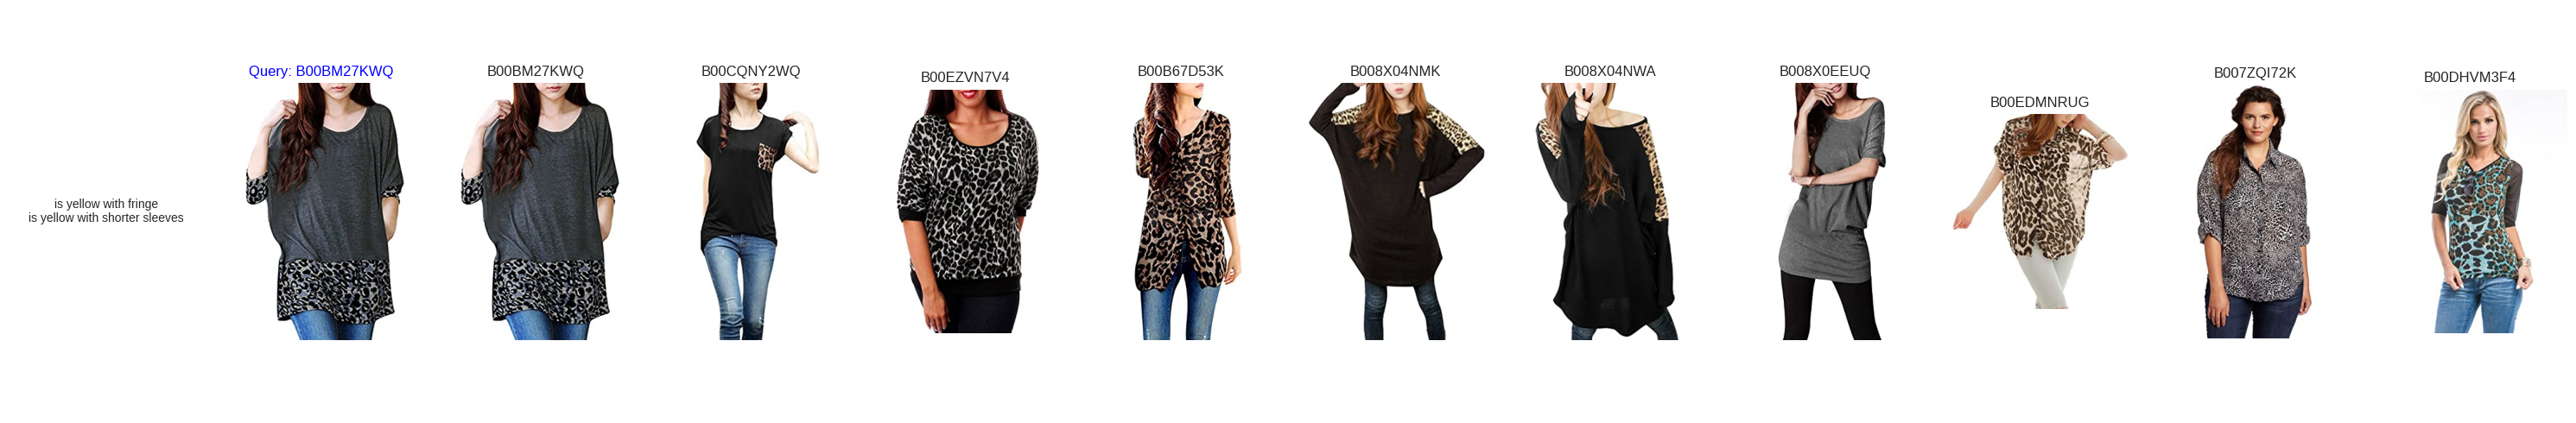

In [49]:
plot_retrieval_results_of_i(sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin, ground_truth_toptee, top_k=10, i=2, directory=DATASET_IMAGE_DIR)